# Project Overview

People seeking care for menstrual irregularity are often told to *“eat healthier”* or *“exercise more”*, but the actual impact of these lifestyle changes is rarely explained. Without clear evidence, patients are left with limited guidance beyond medication.

## Motivation
- Medical visits often emphasize prescriptions over lifestyle counseling.  
- Patients lack population-level data on which behaviors meaningfully improve menstrual regularity.  
- This knowledge gap makes it difficult to make informed health choices.  

## Goal
Identify which lifestyle factors are most strongly associated with menstrual regularity and estimate their effect sizes. The aim is to translate these findings into practical, evidence-based recommendations that complement medical care.  

## Approach
1. **Define Outcomes**  
   - Use cycle regularity measures (e.g., self-reported regular/irregular, variability in cycle length).  

2. **Analyze Lifestyle Factors**  
   - Examine physical activity, diet, sleep, BMI, and related behaviors.  
   - Adjust for confounding variables such as age, parity, contraception, and smoking status.  

3. **Deliver Evidence-Based Guidance**  
   - Report associations with effect sizes and uncertainty.  
   - Present findings in plain language to support both clinical and personal decision-making.  


## Primary Dataset

### Outcome - Menstrual Cycle Regularity

Menstrual cycle regularity in the past 12 months was assessed by asking participants whether they experienced **regular periods**.  
- Participants reporting consistent bleeding patterns were classified as having **regular cycles**.  
- Participants reporting inconsistent or irregular bleeding patterns were classified as having **irregular cycles**, provided no major medical or physiological reason explained the irregularity.  

**Exclusion criteria.**  
To ensure that irregularity reflected only those for whom menstruation would normally be expected, participants were excluded from the irregularity classification if they reported:  
- Pregnancy  
- Postpartum or breastfeeding-related amenorrhea  
- Hysterectomy  
- Menopause  

**Additional quality checks.**  
- **Age** was used to identify and exclude outliers (e.g., implausible reports of menstruation at very young or very advanced ages).  
- **Common-sense rules** were applied to further refine classifications, ensuring the outcome measure represented biologically plausible cases of menstrual cycle regularity.  

This approach ensures that cycle irregularity is measured only among participants for whom menstrual cycles are physiologically expected under normal conditions.



In [2912]:
# Standard library
import warnings

# Third-party
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Global config
mpl.rcParams["axes.grid"] = False

# Suppress warnings
warnings.filterwarnings("ignore")

# Configure seaborn global theme
sns.set_theme(style="whitegrid", palette="husl")

# Define consistent colors
primary_color = sns.color_palette("husl", 8)[0]
secondary_color = sns.color_palette("husl", 8)[6]


#### Dataset 1 - Reproductive Health

We combined reproductive health data from two NHANES cycles (2017–Pre-2020 and 2021–2023) and applied a series of cleaning steps to create a consistent outcome variable for menstrual cycle regularity.

1. **Load datasets**  
   To capture information across survey years, we imported the `P_RHQ.XPT` (2017–Pre-2020) and `RHQ_L.XPT` (2021–2023) reproductive health files.  

2. **Align structure**  
   To ensure compatibility, we identified overlapping columns between the two files and concatenated them into a single DataFrame.  

3. **Rename variables**  
   For readability and consistency, we renamed key variables:  
   - `RHQ031` → `regular_periods`  
   - `RHD043` → `irregular_period_reason`  

4. **Map categorical values**  
   To make responses interpretable, we converted `regular_periods` codes into human-readable labels:  
   - `1 = Yes`  
   - `2 = No`  
   - Other codes defaulted to `NaN`.  

5. **Exclude ineligible cases**  
   To avoid misclassification, we dropped rows where `regular_periods` was missing and excluded participants whose irregularity was explained by natural/medical conditions:  
   - Pregnancy, breastfeeding-related amenorrhea, hysterectomy, or menopause.  

6. **Retain analysis variables**  
   To prepare for downstream merging, we kept only the variables of interest:  
   - `SEQN` (participant ID)  
   - `regular_periods`  

**Outcome:** A cleaned cycle dataset (`cycle_df`) that provides a valid measure of menstrual cycle regularity, restricted to participants for whom menstruation would normally be expected.


In [2913]:
# Load reproductive health datasets (XPT files)
cycle_17_to_pre20 = pd.read_sas("data/P_RHQ.XPT")
cycle_21_to_23 = pd.read_sas("data/RHQ_L.XPT")

# Inspect dataset dimensions
print("Cycle 2017–Pre-2020:", cycle_17_to_pre20.shape)
print("Cycle 2021–2023:", cycle_21_to_23.shape)

Cycle 2017–Pre-2020: (5314, 32)
Cycle 2021–2023: (3917, 13)


In [2914]:
# Resuable to combine more dataset from different years

def combine_nhanes(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    """Combine two NHANES DataFrames on overlapping columns.

    Args:
        df1: First DataFrame.
        df2: Second DataFrame.

    Returns:
        Combined DataFrame containing only the overlapping columns,
        with indices reset.
    """
    common_cols = df1.columns.intersection(df2.columns)

    combined = pd.concat(
        [df1[common_cols], df2[common_cols]],
        axis=0,
        ignore_index=True,
    )
    return combined


# Example usage
cycle_df = combine_nhanes(cycle_17_to_pre20, cycle_21_to_23)
print("Combined shape:", cycle_df.shape)


Combined shape: (9231, 13)


In [2915]:
# Rename variables of interest
cycle_df = cycle_df.rename(
    columns={
        "RHQ031": "Regular_Periods",
        "RHD043": "Irregular_Period_Reason",
    }
)

# Map categorical values (unmapped values will become NaN)
cycle_df["Regular_Periods"] = cycle_df["Regular_Periods"].map(
    {
        1: "Yes",
        2: "No",
    }
)

cycle_df.head()

SEQN  RHQ010 Regular_Periods  Irregular_Period_Reason  RHQ060  RHQ078  \
0  109264.0    12.0             Yes                      NaN     NaN     NaN   
1  109266.0    13.0             Yes                      NaN     NaN     2.0   
2  109277.0    11.0             Yes                      NaN     NaN     NaN   
3  109279.0    12.0             Yes                      NaN     NaN     NaN   
4  109284.0     9.0             Yes                      NaN     NaN     2.0   

   RHQ131  RHD143  RHD167  RHQ200  RHD280  RHQ305  RHQ332  
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
1     2.0     NaN     NaN     NaN     2.0     2.0     NaN  
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
4     1.0     2.0     4.0     NaN     2.0     2.0     NaN

In [2916]:
# Drop rows where regular_periods is NaN
cycle_df = cycle_df.dropna(subset=["Regular_Periods"])

# Exclude rows where irregular_period_reason is due to medical/physiological causes
excluded_reasons = [1, 2, 3, 7]  # pregnancy, breastfeeding, hysterectomy, menopause
cycle_df = cycle_df[~cycle_df["Irregular_Period_Reason"].isin(excluded_reasons)]

# Retain only variables of interest
cycle_df = cycle_df[["SEQN", "Regular_Periods"]]


In [2917]:
cycle_df.head()

SEQN Regular_Periods
0  109264.0             Yes
1  109266.0             Yes
2  109277.0             Yes
3  109279.0             Yes
4  109284.0             Yes

#### Dataset 2 - Demographics

Demographic information was included to provide key covariates (e.g., age, race/ethnicity, education, socioeconomic status) that may influence menstrual cycle regularity and serve as important control variables in analysis.

1. **Load datasets**  
   To capture data across survey years, we imported the `P_DEMO.XPT` (2017–Pre-2020) and `DEMO_L.XPT` (2021–2023) demographic files.  

2. **Align structure**  
   We identified overlapping columns between the two datasets and concatenated them into a single demographic DataFrame.  

3. **Merge with cycle data**  
   The demographic dataset was merged with the cleaned cycle dataset using `SEQN`, the unique participant identifier.  

4. **Rename variables**  
   To improve readability and ensure consistent naming, we renamed selected variables:  
   - `RIDRETH3` → `race`  
   - `RIDAGEYR` → `age`  
   - `DMDEDUC2` → `education`  
   - `INDFMPIR` → `family_income_to_poverty_ratio`  

5. **Map categorical values**  
   We converted coded responses into human-readable categories for race/ethnicity and education.  

6. **Filter participants by age**  
   We restricted the dataset to participants aged **18–50** years:  
   - 18 was chosen as the lower bound because NHANES primarily surveys adults (18+).  
   - 50 was chosen as the upper bound, aligning with medical literature on the typical age range for menopause.  

7. **Select analysis variables**  
   We retained only the key demographic variables needed for downstream analysis:  
   - `SEQN` (participant ID)  
   - `regular_periods` (outcome from cycle data)  
   - `race`  
   - `age`  
   - `education`  
   - `family_income_to_poverty_ratio`  

**Outcome:** A harmonized demographic dataset (`primary_dataset`) providing essential covariates for exploring associations between lifestyle factors and menstrual cycle regularity.

In [2918]:
# Load demographic datasets (XPT files)
demo_17_to_pre20 = pd.read_sas("data/P_DEMO.XPT")
demo_21_to_23 = pd.read_sas("data/DEMO_L.XPT")

# Inspect dataset dimensions
print("Demographics 2017–Pre-2020:", demo_17_to_pre20.shape)
print("Demographics 2021–2023:", demo_21_to_23.shape)

Demographics 2017–Pre-2020: (15560, 29)
Demographics 2021–2023: (11933, 27)


In [2919]:
# Reuse combine_nhanes function to combine the dataset
demo_df = combine_nhanes(demo_17_to_pre20, demo_21_to_23)
print("Combined shape:", demo_df.shape)

Combined shape: (27493, 16)


In [2920]:
# Merge cycle and demographic datasets on SEQN (participant ID)
demo_df = pd.merge(
    cycle_df,
    demo_df,
    on="SEQN",
    how="left",
)


In [2921]:
# Rename demographic variables of interest
# Note: filtering by sex is unnecessary here since cycle data includes only females
demo_df = demo_df.rename(
    columns={
        "RIDRETH3": "Race",
        "RIDAGEYR": "Age",
        "DMDEDUC2": "Education",
        "INDFMPIR": "Family_Income_to_Poverty_Ratio",
    }
)

In [2922]:
# Map categorical values
demo_df["Race"] = demo_df["Race"].map(
    {
        1: "Mexican American",
        2: "Other Hispanic",
        3: "Non-Hispanic White",
        4: "Non-Hispanic Black",
        6: "Non-Hispanic Asian",
        7: "Other Race - Including Multi-Racial",
    }
)

demo_df["Education"] = demo_df["Education"].map(
    {
        1: "Less than 9th grade",
        2: "9–11th grade",
        3: "High school/GED",
        4: "Some college/AA",
        5: "College graduate or above",
    }
)

In [2923]:
demo_df

SEQN Regular_Periods  SDDSRVYR  RIDSTATR  RIAGENDR   Age  RIDAGEMN  \
0     109264.0             Yes      66.0       2.0       2.0  13.0       NaN   
1     109266.0             Yes      66.0       2.0       2.0  29.0       NaN   
2     109277.0             Yes      66.0       2.0       2.0  12.0       NaN   
3     109279.0             Yes      66.0       2.0       2.0  17.0       NaN   
4     109284.0             Yes      66.0       2.0       2.0  44.0       NaN   
...        ...             ...       ...       ...       ...   ...       ...   
4454  142263.0             Yes      12.0       2.0       2.0  44.0       NaN   
4455  142269.0              No      12.0       2.0       2.0  32.0       NaN   
4456  142280.0             Yes      12.0       2.0       2.0  23.0       NaN   
4457  142283.0             Yes      12.0       2.0       2.0  29.0       NaN   
4458  142300.0             Yes      12.0       2.0       2.0  46.0       NaN   

      RIDRETH1                                 Race  RIDEXMON  DMDBORN4  \
0          1.0                     Mexican American       2.0       1.0   
1          5.0                   Non-Hispanic Asian       2.0       2.0   
2          1.0                     Mexican American       1.0       1.0   
3          3.0                   Non-Hispanic White       2.0       1.0   
4          1.0                     Mexican American       1.0       2.0   
...        ...                                  ...       ...       ...   
4454       3.0                   Non-Hispanic White       2.0       1.0   
4455       4.0                   Non-Hispanic Black       2.0       1.0   
4456       5.0  Other Race - Including Multi-Racial       2.0       1.0   
4457       5.0  Other Race - Including Multi-Racial       1.0       1.0   
4458       1.0                     Mexican American       1.0       2.0   

                      Education  DMDMARTZ  RIDEXPRG  SDMVPSU  SDMVSTRA  \
0                           NaN       NaN       NaN      1.0     155.0   
1     College graduate or above       3.0       2.0      2.0     168.0   
2                           NaN       NaN       NaN      2.0     161.0   
3                           NaN       NaN       NaN      2.0     169.0   
4                  9–11th grade       1.0       2.0      1.0     154.0   
...                         ...       ...       ...      ...       ...   
4454  College graduate or above       2.0       2.0      2.0     182.0   
4455            Some college/AA       3.0       2.0      2.0     178.0   
4456            Some college/AA       3.0       2.0      2.0     186.0   
4457            High school/GED       1.0       2.0      2.0     187.0   
4458            High school/GED       1.0       NaN      1.0     179.0   

      Family_Income_to_Poverty_Ratio  
0                               0.83  
1                               5.00  
2                               1.35  
3                               1.19  
4                                NaN  
...                              ...  
4454                             NaN  
4455                            0.74  
4456                            1.40  
4457                            1.04  
4458                            0.68  

[4459 rows x 17 columns]

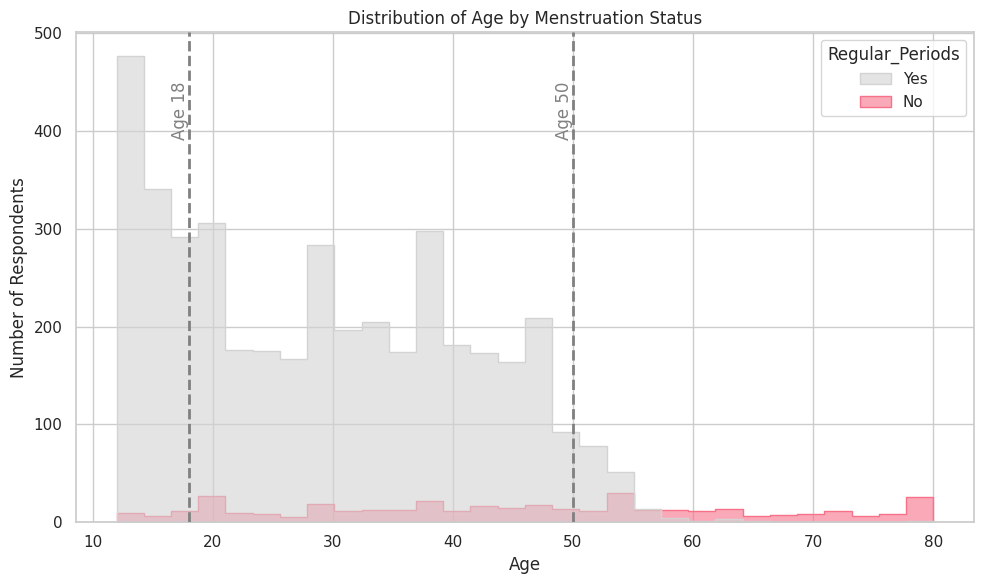

In [2924]:
# Plot a gragh to explore the age and cycle data
plt.figure(figsize=(10, 6))

sns.histplot(
    data=demo_df,
    x="Age",
    hue="Regular_Periods",   # split by menstruation status
    bins=30,
    kde=False,
    element="step",          # outlines for easier comparison
    stat="count",            # alternative: "percent"
    alpha=0.6,
    palette={
        "Yes": "lightgray",
        "No": primary_color,
    },
)

# Add vertical reference lines
plt.axvline(x=18, color="gray", linestyle="--", linewidth=2, zorder=5)
plt.axvline(x=50, color="gray", linestyle="--", linewidth=2, zorder=5)

# Labels for reference lines
plt.text(
    18,
    plt.ylim()[1] * 0.9,
    "Age 18",
    rotation=90,
    color="gray",
    ha="right",
    va="top",
)
plt.text(
    50,
    plt.ylim()[1] * 0.9,
    "Age 50",
    rotation=90,
    color="gray",
    ha="right",
    va="top",
)

plt.title("Distribution of Age by Menstruation Status")
plt.xlabel("Age")
plt.ylabel("Number of Respondents")

plt.tight_layout()
plt.show()


In [2925]:
# Drop rows where age is outside the valid range
# - Lower limit (18): some NHANES datasets only include adults (18+)
# - Upper limit (50): based on medical research on menopause
#   Source: https://www.mayoclinic.org/diseases-conditions/menopause/symptoms-causes/syc-20353397
demo_df = demo_df[(demo_df["Age"] >= 18) & (demo_df["Age"] <= 50)]

# Retain only variables of interest
primary_dataset = demo_df[
    [
        "SEQN",
        "Regular_Periods",
        "Race",
        "Age",
        "Education",
        "Family_Income_to_Poverty_Ratio",
    ]
]


In [2926]:
primary_dataset.head()

SEQN Regular_Periods                Race   Age  \
1  109266.0             Yes  Non-Hispanic Asian  29.0   
4  109284.0             Yes    Mexican American  44.0   
5  109291.0             Yes  Non-Hispanic Asian  42.0   
7  109297.0             Yes  Non-Hispanic Asian  30.0   
8  109312.0             Yes  Non-Hispanic White  48.0   

                   Education  Family_Income_to_Poverty_Ratio  
1  College graduate or above                             5.0  
4               9–11th grade                             NaN  
5  College graduate or above                             NaN  
7            Some college/AA                             NaN  
8  College graduate or above                             5.0

## Secondary Dataset
- Body Measures (height, weight, BMI)
- Smoking (smoking status, frequency, history)
- Alcohol Consumption
- Physical Activity (activity type, frequency, duration, intensity)
- Demographics (age, race/ethnicity, education, income)
- Dietary Data (diet quality, caloric and nutrient intake)
- Sleep Disorders (sleep quality, trouble sleeping, sleep duration)

#### Body Measures (height, weight, BMI)

In [2927]:
# Load body measures dataset XPT file
bmi_17_to_pre20 = pd.read_sas('data/P_BMX.XPT')
bmi_21_to_23 = pd.read_sas('data/BMX_L.XPT')

weight_17_to_pre20 = pd.read_sas('data/P_WHQ.XPT')
weight_21_to_23 = pd.read_sas('data/WHQ_L.XPT')

# See what’s inside
print(bmi_17_to_pre20.shape)
print(bmi_21_to_23.shape)

print(weight_17_to_pre20.shape)
print(weight_21_to_23.shape)

(14300, 22)
(8860, 22)
(10195, 35)
(8501, 5)


In [2928]:
# Find overlapping columns
bmi_common_cols = bmi_17_to_pre20.columns.intersection(bmi_21_to_23.columns)
weight_common_cols = weight_17_to_pre20.columns.intersection(weight_21_to_23.columns)

# Keep only overlapping columns
bmi_df = pd.concat([bmi_17_to_pre20[bmi_common_cols], bmi_21_to_23[bmi_common_cols]], axis=0, ignore_index=True)
weight_df = pd.concat([weight_17_to_pre20[weight_common_cols], weight_21_to_23[weight_common_cols]], axis=0, ignore_index=True)

In [2929]:
# Merge cycle_df and bmi_df on SEQN (common ID)
bmi_df = pd.merge(cycle_df, bmi_df, on='SEQN', how='left')
bmi_df = pd.merge(bmi_df, weight_df, on='SEQN', how='left')

In [2930]:
# Rename variables of interest
bmi_df.rename(columns={
    'BMXBMI': 'BMI',
    'BMXWAIST': 'Waist_circum_cm',
    'BMXHIP': 'Hip_Circum_cm',
    'WHQ070': 'Attempted_Weight_Loss',
    'WHD010': 'Height_in',
    'WHD020': 'Weight_lbs',
    'WHD050': 'Prev_Weight_lbs'
}, inplace=True)

In [2931]:
# Map categorical values
bmi_df['Attempted_Weight_Loss'] = bmi_df['Attempted_Weight_Loss'].map({
    1: 'Yes',
    2: 'No'
})
#Using replace over map since range values need to be retained
bmi_df['Height_in'] = bmi_df['Height_in'].replace(7777, np.nan).replace(9999, np.nan)
bmi_df['Weight_lbs'] = bmi_df['Weight_lbs'].replace(7777, np.nan).replace(9999, np.nan)
bmi_df['Prev_Weight_lbs'] = bmi_df['Prev_Weight_lbs'].replace(7777, np.nan).replace(9999, np.nan)

In [2932]:
# No additional rows need to be dropped

In [2933]:
# Add calculation column for weight loss
bmi_df['Weight_Change_lbs'] = bmi_df['Prev_Weight_lbs'] - bmi_df['Weight_lbs']

In [2934]:
#Retain variables of interest only
bmi_df = bmi_df[['SEQN','BMI', 'Waist_circum_cm', 'Hip_Circum_cm', 'Attempted_Weight_Loss', 'Height_in', 'Weight_lbs', 'Weight_Change_lbs']]

In [2935]:
bmi_df

SEQN   BMI  Waist_circum_cm  Hip_Circum_cm Attempted_Weight_Loss  \
0     109264.0  17.6             63.8           85.0                   NaN   
1     109266.0  37.8            117.9          126.1                   Yes   
2     109277.0  18.6             67.6           88.6                   NaN   
3     109279.0  21.0             77.4           90.3                    No   
4     109284.0  39.1            103.1          125.5                   Yes   
...        ...   ...              ...            ...                   ...   
4454  142263.0  22.6             80.4           95.0                    No   
4455  142269.0   NaN            149.3          147.2                    No   
4456  142280.0  38.4            124.1          130.0                   Yes   
4457  142283.0  45.8            137.2          145.7                   Yes   
4458  142300.0  32.6             97.6          115.4                   Yes   

      Height_in  Weight_lbs  Weight_Change_lbs  
0           NaN         NaN                NaN  
1          64.0       210.0              -10.0  
2           NaN         NaN                NaN  
3          64.0       122.0               -8.0  
4          60.0       178.0               -8.0  
...         ...         ...                ...  
4454       65.0       135.0                0.0  
4455       64.0       350.0                0.0  
4456       69.0       250.0               20.0  
4457       67.0       275.0                5.0  
4458       62.0       169.0                3.0  

[4459 rows x 8 columns]

In [2936]:
#Confirm only specified values remain in fields
print(bmi_df['BMI'].value_counts())

#Check value & N/A counts
print('Values: ',bmi_df['BMI'].value_counts().sum())
print('N/A: ',bmi_df['BMI'].isna().sum())
print('Total: ',bmi_df['BMI'].isna().value_counts().sum())

BMI
26.1    39
22.3    34
21.6    34
22.2    33
22.6    32
        ..
66.2     1
57.9     1
40.3     1
77.3     1
14.9     1
Name: count, Length: 429, dtype: int64
Values:  4418
N/A:  41
Total:  4459


#### Smoking (smoking status, frequency, history)

In [2937]:
# Load smoking dataset XPT files
smoking_cig_17_to_pre20 = pd.read_sas('data/P_SMQ.XPT')
smoking_cig_21_to_23 = pd.read_sas('data/SMQ_L.XPT')

smoking_house_17_to_pre20 = pd.read_sas('data/P_SMQFAM.XPT')
smoking_house_21_to_23 = pd.read_sas('data/SMQFAM_L.XPT')

smoking_tobacco_17_to_pre20 = pd.read_sas('data/P_SMQRTU.XPT')
smoking_tobacco_21_to_23 = pd.read_sas('data/SMQRTU_L.XPT')

# See what’s inside
print(smoking_cig_17_to_pre20.shape)
print(smoking_cig_21_to_23.shape)

print(smoking_house_17_to_pre20.shape)
print(smoking_house_21_to_23.shape)

print(smoking_tobacco_17_to_pre20.shape)
print(smoking_tobacco_21_to_23.shape)

(11137, 16)
(9015, 9)
(15560, 3)
(11933, 3)
(10409, 25)
(7199, 21)


In [2938]:
# Find overlapping columns
smoking_cig_common_cols = smoking_cig_17_to_pre20.columns.intersection(smoking_cig_21_to_23.columns)
smoking_house_common_cols = smoking_house_17_to_pre20.columns.intersection(smoking_house_21_to_23.columns)
smoking_tobacco_common_cols = smoking_tobacco_17_to_pre20.columns.intersection(smoking_tobacco_21_to_23.columns)

# Keep only overlapping columns
smoking_cig = pd.concat([smoking_cig_17_to_pre20[smoking_cig_common_cols], smoking_cig_21_to_23[smoking_cig_common_cols]], axis=0, ignore_index=True)
smoking_house = pd.concat([smoking_house_17_to_pre20[smoking_house_common_cols], smoking_house_21_to_23[smoking_house_common_cols]], axis=0, ignore_index=True)
smoking_tobacco = pd.concat([smoking_tobacco_17_to_pre20[smoking_tobacco_common_cols], smoking_tobacco_21_to_23[smoking_tobacco_common_cols]], axis=0, ignore_index=True)

In [2939]:
# Merge cycle_df and smoking dfs on SEQN (common ID)
smoking_df = pd.merge(cycle_df, smoking_cig, on='SEQN', how='left')
smoking_df = pd.merge(smoking_df, smoking_house, on='SEQN', how='left')
smoking_df = pd.merge(smoking_df, smoking_tobacco, on='SEQN', how='left')

In [2940]:
# Rename variables of interest
smoking_df.rename(columns={
    'SMQ020': 'Smoked_100', 
    'SMQ040': 'Active_Smoker', 
    'SMQ621': 'Lifetime_Cig_Count',
    'SMD460': 'Household_Smoker_Count',
    'SMQ725': 'Last_Cig',
}, inplace=True)

In [2941]:
# Map categorical values
smoking_df['Smoked_100'] = smoking_df['Smoked_100'].map({
    1: 'Yes', 
    2: 'No'})
smoking_df['Active_Smoker'] = smoking_df['Active_Smoker'].map({
    1: 'Every day', 
    2: 'Some days',
    3: 'Not at all'})
smoking_df['Lifetime_Cig_Count'] = smoking_df['Lifetime_Cig_Count'].map({
    1: 0, 
    2: '<1',
    3: 1,
    4: '2 to 5',
    5: '6 to 15',
    6: '16 to 25',
    7: '26 to 99',
    8: '100+'})
smoking_df['Household_Smoker_Count'] = smoking_df['Household_Smoker_Count'].map({
    5.397605346934028e-79: 0, #0 is being interpreted as 5.397605346934028e-79, the lowest IBM float value
    1: 1,
    2: '2+'})
smoking_df['Last_Cig'] = smoking_df['Last_Cig'].map({
    1: 'Today', 
    2: 'Yesterday',
    3: '3 to 5 days ago'})

In [2942]:
# No additional rows need to be dropped

In [2943]:
#Retain variables of interest only
smoking_df = smoking_df[['SEQN', 'Smoked_100', 'Active_Smoker', 'Lifetime_Cig_Count', 'Household_Smoker_Count', 'Last_Cig']]

In [2944]:
smoking_df

SEQN Smoked_100 Active_Smoker Lifetime_Cig_Count  \
0     109264.0        NaN           NaN                  0   
1     109266.0         No           NaN                NaN   
2     109277.0        NaN           NaN                  0   
3     109279.0        NaN           NaN                  0   
4     109284.0         No           NaN                NaN   
...        ...        ...           ...                ...   
4454  142263.0         No           NaN                NaN   
4455  142269.0         No           NaN                NaN   
4456  142280.0         No           NaN                NaN   
4457  142283.0         No           NaN                NaN   
4458  142300.0        Yes    Not at all                NaN   

     Household_Smoker_Count Last_Cig  
0                         0      NaN  
1                         0      NaN  
2                         0      NaN  
3                         0      NaN  
4                         0      NaN  
...                     ...      ...  
4454                      0      NaN  
4455                      0      NaN  
4456                      0      NaN  
4457                      0      NaN  
4458                      0      NaN  

[4459 rows x 6 columns]

In [2945]:
#Confirm only specified values remain in fields
print(smoking_df['Smoked_100'].value_counts())

#Check value & N/A counts
print('Values: ',smoking_df['Smoked_100'].value_counts().sum())
print('N/A: ',smoking_df['Smoked_100'].isna().sum())
print('Total: ',smoking_df['Smoked_100'].isna().value_counts().sum())

Smoked_100
No     2528
Yes     931
Name: count, dtype: int64
Values:  3459
N/A:  1000
Total:  4459


#### Alcohol

In [2946]:
# Load alcohol dataset XPT files
alcohol_17_to_pre20 = pd.read_sas('data/P_ALQ.XPT')
alcohol_21_to_23 = pd.read_sas('data/ALQ_L.XPT')

# See what’s inside
print(alcohol_17_to_pre20.shape)
print(alcohol_21_to_23.shape)

(8965, 10)
(6337, 9)


In [2947]:
# Find overlapping columns
alcohol_common_cols = alcohol_17_to_pre20.columns.intersection(alcohol_21_to_23.columns)

# Keep only overlapping columns
alcohol_df = pd.concat([alcohol_17_to_pre20[alcohol_common_cols], alcohol_21_to_23[alcohol_common_cols]], axis=0, ignore_index=True)

In [2948]:
# Merge cycle_df and alcohol_df on SEQN (common ID)
alcohol_df = pd.merge(cycle_df, alcohol_df, on='SEQN', how='left')

In [2949]:
# Rename variables of interest
alcohol_df.rename(columns={
    'ALQ121': 'Alc_Freq', 
    'ALQ130': 'Daily_Drinks',
}, inplace=True)

In [2950]:
# Map categorical values
alcohol_df['Alc_Freq'] = alcohol_df['Alc_Freq'].map({
    5.397605346934028e-79: 'Never', #0 is being interpreted as 5.397605346934028e-79, the lowest IBM float value
    1: 'Every Day',
    2: 'Nearly Every Day',
    3: '3-4x/wk',
    4: '2x/wk',
    5: '1x/wk',
    6: '2-3x/mo',
    7: '1x/mo',
    8: '7-11x/yr',
    9: '3-6x/yr',
    10: '1-2x/yr'
})
#Using replace over map since range values need to be retained
alcohol_df['Daily_Drinks'] = alcohol_df['Daily_Drinks'].replace(15, '15+' ).replace(777, np.nan).replace(999, np.nan)

In [2951]:
# No additional rows need to be dropped

In [2952]:
#Retain variables of interest only
alcohol_df = alcohol_df[['SEQN', 'Alc_Freq', 'Daily_Drinks']]

In [2953]:
alcohol_df

SEQN Alc_Freq Daily_Drinks
0     109264.0      NaN          NaN
1     109266.0  1-2x/yr          1.0
2     109277.0      NaN          NaN
3     109279.0      NaN          NaN
4     109284.0      NaN          NaN
...        ...      ...          ...
4454  142263.0    Never          NaN
4455  142269.0  3-6x/yr          2.0
4456  142280.0  1-2x/yr          3.0
4457  142283.0  2-3x/mo          2.0
4458  142300.0  2-3x/mo          6.0

[4459 rows x 3 columns]

In [2954]:
#Confirm only specified values remain in fields
print(alcohol_df['Alc_Freq'].value_counts())

#Check value & N/A counts
print('Values: ',alcohol_df['Alc_Freq'].value_counts().sum())
print('N/A: ',alcohol_df['Alc_Freq'].isna().sum())
print('Total: ',alcohol_df['Alc_Freq'].isna().value_counts().sum())

Alc_Freq
2-3x/mo             540
1-2x/yr             435
3-6x/yr             434
Never               366
1x/mo               276
2x/wk               249
1x/wk               243
7-11x/yr            206
3-4x/wk             185
Nearly Every Day     71
Every Day            34
Name: count, dtype: int64
Values:  3039
N/A:  1420
Total:  4459


#### Physical Activity

In [2955]:
# Load physical activity dataset XPT files
exercise_17_to_pre20 = pd.read_sas('data/P_PAQ.XPT')
exercise_21_to_23 = pd.read_sas('data/PAQ_L.XPT')

# See what’s inside
print(exercise_17_to_pre20.shape)
print(exercise_21_to_23.shape)

(9693, 17)
(8153, 8)


In [2956]:
# Keep all columns
exercise_df = pd.concat([exercise_17_to_pre20, exercise_21_to_23], axis=0, ignore_index=True)

In [2957]:
# Merge cycle_df and exercise_df on SEQN (common ID)
exercise_df = pd.merge(cycle_df, exercise_df, on='SEQN', how='left')

In [2958]:
# Rename variables of interest
exercise_df.rename(columns={
    'PAD680': 'Sedentary_Mins',
    'PAD790Q': 'Moderate_LTPA_Freq_1',
    'PAD790U': 'Moderate_LTPA_Units',
    'PAD800': 'Moderate_LTPA_Mins_1',
    'PAD810Q': 'Vigorous_LTPA_Freq_1',
    'PAD810U': 'Vigorous_LTPA_Units',
    'PAD820': 'Vigorous_LTPA_Mins_1',
    'PAQ610': 'Vigorous_LTPA_Freq_Work',
    'PAD615': 'Vigorous_LTPA_Mins_Work',
    'PAQ625': 'Moderate_LTPA_Freq_Work',
    'PAD630': 'Moderate_LTPA_Mins_Work',
    'PAQ655': 'Vigorous_LTPA_Freq_Rec',
    'PAD660': 'Vigorous_LTPA_Mins_Rec',
    'PAQ670': 'Moderate_LTPA_Freq_Rec',
    'PAD675': 'Moderate_LTPA_Mins_Rec'
}, inplace=True)

In [2959]:
# Map categorical values
exercise_df['Moderate_LTPA_Units_Math'] = exercise_df['Moderate_LTPA_Units'].map({
    b'D': 365,
    b'M': 12,
    b'W': 52,
    b'Y': 1
})
exercise_df['Moderate_LTPA_Units_Text'] = exercise_df['Moderate_LTPA_Units'].map({
    b'D': 'day(s)',
    b'M': 'month(s)',
    b'W': 'week(s)',
    b'Y': 'year(s)'
})
exercise_df['Vigorous_LTPA_Units_Math'] = exercise_df['Vigorous_LTPA_Units'].map({
    b'D': 365,
    b'M': 12,
    b'W': 52,
    b'Y': 1
})
exercise_df['Vigorous_LTPA_Units_Text'] = exercise_df['Vigorous_LTPA_Units'].map({
    b'D': 'day(s)',
    b'M': 'month(s)',
    b'W': 'week(s)',
    b'Y': 'year(s)'
})

# Using replace over map since range values need to be retained
exercise_df['Sedentary_Mins'] = exercise_df['Sedentary_Mins'].replace(7777, np.nan).replace(9999, np.nan)

exercise_df['Moderate_LTPA_Freq_1'] = exercise_df['Moderate_LTPA_Freq_1'].replace(5.397605346934028e-79, 0).replace(7777, np.nan).replace(9999, np.nan)
exercise_df['Moderate_LTPA_Mins_1'] = exercise_df['Moderate_LTPA_Mins_1'].replace(7777, np.nan).replace(9999, np.nan)

exercise_df['Vigorous_LTPA_Freq_1'] = exercise_df['Vigorous_LTPA_Freq_1'].replace(5.397605346934028e-79, 0).replace(7777, np.nan).replace(9999, np.nan)
exercise_df['Vigorous_LTPA_Mins_1'] = exercise_df['Vigorous_LTPA_Mins_1'].replace(7777, np.nan).replace(9999, np.nan)

exercise_df['Moderate_LTPA_Freq_Work'] = exercise_df['Moderate_LTPA_Freq_Work'].replace(77, np.nan).replace(99, np.nan)
exercise_df['Moderate_LTPA_Mins_Work'] = exercise_df['Moderate_LTPA_Mins_Work'].replace(7777, np.nan).replace(9999, np.nan)

exercise_df['Vigorous_LTPA_Freq_Work'] = exercise_df['Vigorous_LTPA_Freq_Work'].replace(77, np.nan).replace(99, np.nan)
exercise_df['Vigorous_LTPA_Mins_Work'] = exercise_df['Vigorous_LTPA_Mins_Work'].replace(7777, np.nan).replace(9999, np.nan)

exercise_df['Moderate_LTPA_Freq_Rec'] = exercise_df['Moderate_LTPA_Freq_Rec'].replace(77, np.nan).replace(99, np.nan)
exercise_df['Moderate_LTPA_Mins_Rec'] = exercise_df['Moderate_LTPA_Mins_Rec'].replace(7777, np.nan).replace(9999, np.nan)

exercise_df['Vigorous_LTPA_Freq_Rec'] = exercise_df['Vigorous_LTPA_Freq_Rec'].replace(77, np.nan).replace(99, np.nan)
exercise_df['Vigorous_LTPA_Mins_Rec'] = exercise_df['Vigorous_LTPA_Mins_Rec'].replace(7777, np.nan).replace(9999, np.nan)

In [2960]:
# No additional rows need to be dropped

In [2961]:
# Add calculation columns for hrs per day & year
exercise_df['Sedentary_Hrs_Wk'] = exercise_df['Sedentary_Mins'] / 60 * 7

# Add calculation column for hrs per week avg
exercise_df['Moderate_LTPA_Hrs_Wk_1'] = exercise_df['Moderate_LTPA_Freq_1'] * exercise_df['Moderate_LTPA_Units_Math'].fillna(0).astype(int) * exercise_df['Moderate_LTPA_Mins_1'] / 60 / 52
exercise_df['Vigorous_LTPA_Hrs_Wk_1'] = exercise_df['Vigorous_LTPA_Freq_1'] * exercise_df['Vigorous_LTPA_Units_Math'].fillna(0).astype(int) * exercise_df['Vigorous_LTPA_Mins_1'] / 60 / 52
exercise_df['Moderate_LTPA_Hrs_Wk_Work'] = exercise_df['Moderate_LTPA_Freq_Work'] * exercise_df['Moderate_LTPA_Mins_Work'] / 60
exercise_df['Moderate_LTPA_Hrs_Wk_Rec'] = exercise_df['Moderate_LTPA_Freq_Rec'] * exercise_df['Moderate_LTPA_Mins_Rec'] / 60
exercise_df['Vigorous_LTPA_Hrs_Wk_Work'] = exercise_df['Vigorous_LTPA_Freq_Work'] * exercise_df['Vigorous_LTPA_Mins_Work'] / 60
exercise_df['Vigorous_LTPA_Hrs_Wk_Rec'] = exercise_df['Vigorous_LTPA_Freq_Rec'] * exercise_df['Vigorous_LTPA_Mins_Rec'] / 60

# Combine work & rec hrs per week fields
exercise_df['Moderate_LTPA_Hrs_Wk_2'] = exercise_df['Moderate_LTPA_Hrs_Wk_Work'] + exercise_df['Moderate_LTPA_Hrs_Wk_Rec']
exercise_df['Vigorous_LTPA_Hrs_Wk_2'] = exercise_df['Vigorous_LTPA_Hrs_Wk_Work'] + exercise_df['Vigorous_LTPA_Hrs_Wk_Rec']

# Combine hrs per week fields from 17-20 & 21-23 files
exercise_df['Moderate_LTPA_Hrs_Wk'] = exercise_df['Moderate_LTPA_Hrs_Wk_1'].combine_first(exercise_df['Moderate_LTPA_Hrs_Wk_2'])
exercise_df['Vigorous_LTPA_Hrs_Wk'] = exercise_df['Vigorous_LTPA_Hrs_Wk_1'].combine_first(exercise_df['Vigorous_LTPA_Hrs_Wk_2'])

# Combine work & rec freq fields
exercise_df['Moderate_LTPA_Freq_2'] = exercise_df['Moderate_LTPA_Freq_Work'] + exercise_df['Moderate_LTPA_Freq_Rec']
exercise_df['Vigorous_LTPA_Freq_2'] = exercise_df['Vigorous_LTPA_Freq_Work'] + exercise_df['Vigorous_LTPA_Freq_Rec']

# Combine work & rec mins fields
exercise_df['Moderate_LTPA_Mins_2'] = exercise_df['Moderate_LTPA_Mins_Work'] + exercise_df['Moderate_LTPA_Mins_Rec']
exercise_df['Vigorous_LTPA_Mins_2'] = exercise_df['Vigorous_LTPA_Mins_Work'] + exercise_df['Vigorous_LTPA_Mins_Rec']

# Modify freq field to include units
exercise_df['Moderate_LTPA_Freq_Units_1'] = exercise_df['Moderate_LTPA_Freq_1'].astype(str) + 'x/ ' + exercise_df['Moderate_LTPA_Units_Text']
exercise_df['Vigorous_LTPA_Freq_Units_1'] = exercise_df['Vigorous_LTPA_Freq_1'].astype(str) + 'x/ ' + exercise_df['Vigorous_LTPA_Units_Text']
exercise_df['Moderate_LTPA_Freq_Units_2'] = exercise_df['Moderate_LTPA_Freq_2'].where(exercise_df['Moderate_LTPA_Freq_2'].isna(), exercise_df['Moderate_LTPA_Freq_2'].astype(str) + 'x/ week')
exercise_df['Vigorous_LTPA_Freq_Units_2'] = exercise_df['Vigorous_LTPA_Freq_2'].where(exercise_df['Vigorous_LTPA_Freq_2'].isna(), exercise_df['Vigorous_LTPA_Freq_2'].astype(str) + 'x/ week')

# Combine freq fields from 17-20 & 21-23 files
exercise_df['Moderate_LTPA_Freq'] = exercise_df['Moderate_LTPA_Freq_Units_1'].combine_first(exercise_df['Moderate_LTPA_Freq_Units_2'])
exercise_df['Vigorous_LTPA_Freq'] = exercise_df['Vigorous_LTPA_Freq_Units_1'].combine_first(exercise_df['Vigorous_LTPA_Freq_Units_2'])

# Combine mins fields from 17-20 & 21-23 files
exercise_df['Moderate_LTPA_Mins'] = exercise_df['Moderate_LTPA_Mins_1'].combine_first(exercise_df['Moderate_LTPA_Mins_2'])
exercise_df['Vigorous_LTPA_Mins'] = exercise_df['Vigorous_LTPA_Mins_1'].combine_first(exercise_df['Vigorous_LTPA_Mins_2'])

In [2962]:
#Retain variables of interest only
exercise_df = exercise_df[['SEQN', 'Sedentary_Hrs_Wk', 'Moderate_LTPA_Freq', 'Moderate_LTPA_Mins', 'Moderate_LTPA_Hrs_Wk', 'Vigorous_LTPA_Freq', 'Vigorous_LTPA_Mins', 'Vigorous_LTPA_Hrs_Wk']]

In [2963]:
exercise_df

SEQN  Sedentary_Hrs_Wk Moderate_LTPA_Freq  Moderate_LTPA_Mins  \
0     109264.0               NaN                NaN                 NaN   
1     109266.0              56.0                NaN                 NaN   
2     109277.0               NaN                NaN                 NaN   
3     109279.0               NaN                NaN                 NaN   
4     109284.0              42.0                NaN                 NaN   
...        ...               ...                ...                 ...   
4454  142263.0              56.0      5.0x/ week(s)                90.0   
4455  142269.0              70.0                NaN                 NaN   
4456  142280.0              21.0      1.0x/ week(s)               120.0   
4457  142283.0              35.0                NaN                 NaN   
4458  142300.0              10.5                NaN                 NaN   

      Moderate_LTPA_Hrs_Wk Vigorous_LTPA_Freq  Vigorous_LTPA_Mins  \
0                      NaN                NaN                 NaN   
1                      NaN                NaN                 NaN   
2                      NaN                NaN                 NaN   
3                      NaN                NaN                 NaN   
4                      NaN                NaN                 NaN   
...                    ...                ...                 ...   
4454                   7.5      5.0x/ week(s)                90.0   
4455                   NaN                NaN                 NaN   
4456                   2.0      1.0x/ week(s)                60.0   
4457                   NaN      2.0x/ week(s)                60.0   
4458                   NaN                NaN                 NaN   

      Vigorous_LTPA_Hrs_Wk  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
...                    ...  
4454                   7.5  
4455                   NaN  
4456                   1.0  
4457                   2.0  
4458                   NaN  

[4459 rows x 8 columns]

In [2964]:
# Confirm only specified values remain in fields
print(exercise_df['Moderate_LTPA_Hrs_Wk'].value_counts())

# Check value & N/A counts
print('Values: ',exercise_df['Moderate_LTPA_Hrs_Wk'].value_counts().sum())
print('N/A: ',exercise_df['Moderate_LTPA_Hrs_Wk'].isna().sum())
print('Total: ',exercise_df['Moderate_LTPA_Hrs_Wk'].isna().value_counts().sum())

Moderate_LTPA_Hrs_Wk
3.000000      115
1.000000      106
2.000000      101
1.500000       94
4.000000       59
             ... 
36.500000       1
49.000000       1
9.250000        1
118.000000      1
0.083333        1
Name: count, Length: 240, dtype: int64
Values:  1559
N/A:  2900
Total:  4459


#### Dietary

In [2965]:
# Load dietary dataset XPT files
dietary_behavior_17_to_pre20 = pd.read_sas('data/P_DBQ.XPT')
dietary_behavior_21_to_23 = pd.read_sas('data/DBQ_L.XPT')

dietary_interview_17_to_pre20 = pd.read_sas('data/P_DR1TOT.XPT')
dietary_interview_21_to_23 = pd.read_sas('data/DR1TOT_L.XPT')

weight_history_17_to_pre20 = pd.read_sas('data/P_WHQ.XPT')
weight_history_21_to_23 = pd.read_sas('data/WHQ_L.XPT')

dietary_supp_17_to_pre20 = pd.read_sas('data/P_DSQTOT.XPT')
dietary_supp_21_to_23 = pd.read_sas('data/DSQTOT_L.XPT')

In [2966]:
# Keep all columns
dietary_behavior = pd.concat([dietary_behavior_17_to_pre20, dietary_behavior_21_to_23], axis=0, ignore_index=True)
dietary_interview = pd.concat([dietary_interview_17_to_pre20, dietary_interview_21_to_23], axis=0, ignore_index=True)
weight_history = pd.concat([weight_history_17_to_pre20, weight_history_21_to_23], axis=0, ignore_index=True)
dietary_supp = pd.concat([dietary_supp_17_to_pre20, dietary_supp_21_to_23], axis=0, ignore_index=True)

In [2967]:
# Merge cycle and dietary on SEQN (common ID)
dietary_df = pd.merge(cycle_df, dietary_behavior, on='SEQN', how='left')
dietary_df = pd.merge(dietary_df, dietary_interview, on='SEQN', how='left')
dietary_df = pd.merge(dietary_df, weight_history, on='SEQN', how='left')
dietary_df = pd.merge(dietary_df, dietary_supp, on='SEQN', how='left')

In [2968]:
# Rename variables of interest
dietary_df.rename(columns={
    'DBQ700': 'Healthiness',
    'DBD895': 'Meals_Not_From_Home_Wk',
    'DBD900': 'Meals_From_Fast_Food_Wk',
    'DRQSPREP': 'Salt_Used',
    'DRQSDIET': 'On_Diet',
    'DR1_320Z': 'Water_Day',
    'WHD080A': 'Ate_Less',
    'WHD080B': 'Lower_Cals',
    'WHD080C': 'Less_Fat',
    'WHD080E': 'Skipped_Meals',
    'WHD080F': 'Diet_Foods',
    'WHD080O': 'Fewer_Carbs',
    'WHD080S': 'Less_Sugar',
    'WHD080T': 'Less_Junk',
    'DSD010': 'Dietary_Supp'
}, inplace=True)

In [2969]:
# Map categorical values
dietary_df['Healthiness'] = dietary_df['Healthiness'].map({
    1: 'Excellent',
    2: 'Very good',
    3: 'Good',
    4: 'Fair',
    5: 'Poor'
})

dietary_df['Salt_Used'] = dietary_df['Salt_Used'].map({
    1: 'Never',
    2: 'Rarely',
    3: 'Occasionally',
    4: 'Very often'
})

dietary_df['On_Diet'] = dietary_df['On_Diet'].map({
    1: 'Yes',
    2: 'No'
})

dietary_df['Dietary_Supp'] = dietary_df['Dietary_Supp'].map({
    1: 'Yes',
    2: 'No'
})

#Using replace over map since range values need to be retained
dietary_df['Meals_Not_From_Home_Wk'] = dietary_df['Meals_Not_From_Home_Wk'].replace(5.397605346934028e-79, 'None').replace(5555, '>21').replace([7777, 9999], np.nan)
dietary_df['Meals_From_Fast_Food_Wk'] = dietary_df['Meals_From_Fast_Food_Wk'].replace(5.397605346934028e-79, 'None').replace(5555, '>21').replace([7777, 9999], np.nan)
dietary_df['Ate_Less'] = dietary_df['Ate_Less'].replace(10, 'Ate less')
dietary_df['Lower_Cals'] = dietary_df['Lower_Cals'].replace(11, 'Lower cals')
dietary_df['Less_Fat'] = dietary_df['Less_Fat'].replace(12, 'Less fat')
dietary_df['Skipped_Meals'] = dietary_df['Skipped_Meals'].replace(14, 'Skipped meals')
dietary_df['Diet_Foods'] = dietary_df['Diet_Foods'].replace(15, 'Diet foods')
dietary_df['Fewer_Carbs'] = dietary_df['Fewer_Carbs'].replace(41, 'Fewer carbs')
dietary_df['Less_Sugar'] = dietary_df['Less_Sugar'].replace(45, 'Less sugar')
dietary_df['Less_Junk'] = dietary_df['Less_Junk'].replace(46, 'Less junk')

In [2970]:
# No additional rows need to be dropped

In [2971]:
# No additional calculation columns needed

In [2972]:
#Retain variables of interest only
dietary_df = dietary_df[['SEQN','Healthiness', 'Meals_Not_From_Home_Wk', 'Meals_From_Fast_Food_Wk', 'Salt_Used', 'On_Diet', 'Water_Day', 'Ate_Less', 'Lower_Cals', 'Less_Fat', 'Skipped_Meals', 'Diet_Foods', 'Fewer_Carbs', 'Less_Sugar', 'Less_Junk', 'Dietary_Supp']]


In [2973]:
dietary_df

SEQN Healthiness Meals_Not_From_Home_Wk Meals_From_Fast_Food_Wk  \
0     109264.0         NaN                    1.0                    None   
1     109266.0        Good                    7.0                    None   
2     109277.0         NaN                    2.0                     2.0   
3     109279.0   Very good                    5.0                     5.0   
4     109284.0        Good                    1.0                    None   
...        ...         ...                    ...                     ...   
4454  142263.0         NaN                    NaN                     NaN   
4455  142269.0         NaN                    NaN                     NaN   
4456  142280.0         NaN                    NaN                     NaN   
4457  142283.0         NaN                    NaN                     NaN   
4458  142300.0         NaN                    NaN                     NaN   

       Salt_Used On_Diet  Water_Day Ate_Less  Lower_Cals Less_Fat  \
0     Very often      No     1640.0      NaN         NaN      NaN   
1     Very often     Yes     2268.9      NaN  Lower cals      NaN   
2     Very often      No      253.5      NaN         NaN      NaN   
3     Very often      No     1074.0      NaN         NaN      NaN   
4     Very often      No     1965.0      NaN  Lower cals      NaN   
...          ...     ...        ...      ...         ...      ...   
4454  Very often      No      811.2      NaN         NaN      NaN   
4455  Very often      No     1920.0      NaN         NaN      NaN   
4456  Very often     Yes     1920.0      NaN         NaN      NaN   
4457         NaN     NaN        NaN      NaN         NaN      NaN   
4458  Very often      No     1785.0      NaN         NaN      NaN   

     Skipped_Meals Diet_Foods  Fewer_Carbs Less_Sugar  Less_Junk Dietary_Supp  
0              NaN        NaN          NaN        NaN        NaN           No  
1              NaN        NaN          NaN        NaN  Less junk           No  
2              NaN        NaN          NaN        NaN        NaN          Yes  
3              NaN        NaN          NaN        NaN        NaN           No  
4              NaN        NaN  Fewer carbs        NaN  Less junk          Yes  
...            ...        ...          ...        ...        ...          ...  
4454           NaN        NaN          NaN        NaN        NaN          Yes  
4455           NaN        NaN          NaN        NaN        NaN           No  
4456           NaN        NaN          NaN        NaN        NaN           No  
4457           NaN        NaN          NaN        NaN        NaN          NaN  
4458           NaN        NaN          NaN        NaN        NaN           No  

[4459 rows x 16 columns]

In [2974]:
#Confirm only specified values remain in fields
print(dietary_df['Healthiness'].value_counts())

#Check value & N/A counts
print('Values: ',dietary_df['Healthiness'].value_counts().sum())
print('N/A: ',dietary_df['Healthiness'].isna().sum())
print('Total: ',dietary_df['Healthiness'].isna().value_counts().sum())

Healthiness
Good         940
Fair         694
Very good    411
Poor         192
Excellent    127
Name: count, dtype: int64
Values:  2364
N/A:  2095
Total:  4459


#### Sleep

In [2975]:
# Load smoking dataset XPT files
sleep_17_to_pre20 = pd.read_sas('data/P_SLQ.XPT')
sleep_21_to_23 = pd.read_sas('data/SLQ_L.XPT')

# See what’s inside
print(sleep_17_to_pre20.shape)
print(sleep_21_to_23.shape)

(10195, 11)
(8501, 7)


In [2976]:
# Keep all columns
sleep_df = pd.concat([sleep_17_to_pre20, sleep_21_to_23], axis=0, ignore_index=True)

In [2977]:
# Merge cycle and sleep on SEQN (common ID)
sleep_df = pd.merge(cycle_df, sleep_df, on='SEQN', how='left')

In [2978]:
# Rename variables of interest
sleep_df.rename(columns={
    'SLQ300': 'Work_Sleep_Time', 
    'SLQ310': 'Work_Wake_Time', 
    'SLD012': 'Work_Sleep_Hrs', 
    'SLQ320': 'Nonwork_Sleep_Time', 
    'SLQ330': 'Nonwork_Wake_Time',
    'SLD013': 'Nonwork_Sleep_Hrs',
    'SLQ050': 'Trouble_Sleeping',
    'SLQ120': 'Daytime_Sleepy'
}, inplace=True)

In [2979]:
# Map categorical values
sleep_df['Trouble_Sleeping'] = sleep_df['Trouble_Sleeping'].map({
    1: 'Yes', 
    2: 'No'})
sleep_df['Daytime_Sleepy'] = sleep_df['Daytime_Sleepy'].map({
    5.397605346934028e-79: 'Never',
    1: 'Rarely', 
    2: 'Sometimes',
    3: 'Often',
    4: 'Almost always'})

# Using replace over map since range values need to be retained
sleep_df['Work_Sleep_Time'] = sleep_df['Work_Sleep_Time'].replace([77777, 99999], np.nan)
sleep_df['Work_Wake_Time'] = sleep_df['Work_Wake_Time'].replace([77777, 99999], np.nan)
sleep_df['Work_Sleep_Hrs'] = sleep_df['Work_Sleep_Hrs'].replace(2, '< 3').replace(14, '>= 14')
sleep_df['Nonwork_Sleep_Time'] = sleep_df['Work_Sleep_Time'].replace([77777, 99999], np.nan)
sleep_df['Nonwork_Wake_Time'] = sleep_df['Work_Sleep_Time'].replace([77777, 99999], np.nan)
sleep_df['Nonwork_Sleep_Hrs'] = sleep_df['Nonwork_Sleep_Hrs'].replace(2, '< 3').replace(14, '>= 14')

In [2980]:
# No additional rows need to be dropped

In [2981]:
#Convert time into hour #'s
sleep_df['Work_Sleep_Time_Decoded'] = sleep_df['Work_Sleep_Time'].str.decode('utf-8')
sleep_df['Work_Sleep_Time_Decoded'] = pd.to_datetime(sleep_df['Work_Sleep_Time_Decoded'], format='%H:%M', errors='coerce').dt.hour

sleep_df['Work_Wake_Time_Decoded'] = sleep_df['Work_Wake_Time'].str.decode('utf-8')
sleep_df['Work_Wake_Time_Decoded'] = pd.to_datetime(sleep_df['Work_Wake_Time_Decoded'], format='%H:%M', errors='coerce').dt.hour

sleep_df['Nonwork_Sleep_Time_Decoded'] = sleep_df['Nonwork_Sleep_Time'].str.decode('utf-8')
sleep_df['Nonwork_Sleep_Time_Decoded'] = pd.to_datetime(sleep_df['Nonwork_Sleep_Time_Decoded'], format='%H:%M', errors='coerce').dt.hour

sleep_df['Nonwork_Wake_Time_Decoded'] = sleep_df['Nonwork_Wake_Time'].str.decode('utf-8')
sleep_df['Nonwork_Wake_Time_Decoded'] = pd.to_datetime(sleep_df['Nonwork_Wake_Time_Decoded'], format='%H:%M', errors='coerce').dt.hour


# Split into early, average, or late sleep/wake time
sleep_df['Work_Sleep_Time_Category'] = pd.cut(
    sleep_df['Work_Sleep_Time_Decoded'], 
    bins=[0, 22, 24, 25], 
    labels=['Early (before 10pm)', 'Normal (10pm-12am)', 'Late (after 12am)'],
    include_lowest=True,
    right=False
)

sleep_df['Work_Wake_Time_Category'] = pd.cut(
    sleep_df['Work_Wake_Time_Decoded'], 
    bins=[0, 6, 8, 24],
    labels=['Early (before 6am)', 'Normal (6am-8am)', 'Late (after 8am)'],
    include_lowest=True,
    right=False
)

sleep_df['Nonwork_Sleep_Time_Category'] = pd.cut(
    sleep_df['Nonwork_Sleep_Time_Decoded'], 
    bins=[0, 22, 24, 25], 
    labels=['Early (before 10pm)', 'Normal (10pm-12am)', 'Late (after 12am)'],
    include_lowest=True,
    right=False
)

sleep_df['Nonwork_Wake_Time_Category'] = pd.cut(
    sleep_df['Nonwork_Wake_Time_Decoded'], 
    bins=[0, 6, 8, 24],
    labels=['Early (before 6am)', 'Normal (6am-8am)', 'Late (after 8am)'],
    include_lowest=True,
    right=False
)

#Convert # into numeric
sleep_df['Work_Sleep_Hrs'] = pd.to_numeric(sleep_df['Work_Sleep_Hrs'], errors='coerce')
sleep_df['Nonwork_Sleep_Hrs'] = pd.to_numeric(sleep_df['Nonwork_Sleep_Hrs'], errors='coerce')

# Split into short, average, or long time spent sleeping
sleep_df['Work_Sleep_Hrs_Category'] = pd.cut(
    sleep_df['Work_Sleep_Hrs'], 
    bins=[0, 7, 9, 24],
    labels=['Short (<7hrs)', 'Normal (7-9hrs)', 'Long (>9hrs)'],
    include_lowest=True,
    right=False
)

sleep_df['Nonwork_Sleep_Hrs_Category'] = pd.cut(
    sleep_df['Nonwork_Sleep_Hrs'], 
    bins=[0, 7, 9, 24],
    labels=['Short (<7hrs)', 'Normal (7-9hrs)', 'Long (>9hrs)'],
    include_lowest=True,
    right=False
)

In [2982]:
# Retain variables of interest only
sleep_df = sleep_df[['SEQN', 'Work_Sleep_Time_Category', 'Work_Wake_Time_Category', 'Work_Sleep_Hrs', 'Work_Sleep_Hrs_Category', 'Nonwork_Sleep_Time_Category', 'Nonwork_Wake_Time_Category', 'Nonwork_Sleep_Hrs', 'Nonwork_Sleep_Hrs_Category', 'Trouble_Sleeping', 'Daytime_Sleepy']]


In [2983]:
sleep_df

SEQN Work_Sleep_Time_Category Work_Wake_Time_Category  \
0     109264.0                      NaN                     NaN   
1     109266.0       Normal (10pm-12am)      Early (before 6am)   
2     109277.0                      NaN                     NaN   
3     109279.0      Early (before 10pm)      Early (before 6am)   
4     109284.0       Normal (10pm-12am)        Normal (6am-8am)   
...        ...                      ...                     ...   
4454  142263.0       Normal (10pm-12am)        Normal (6am-8am)   
4455  142269.0      Early (before 10pm)        Late (after 8am)   
4456  142280.0      Early (before 10pm)        Late (after 8am)   
4457  142283.0      Early (before 10pm)        Late (after 8am)   
4458  142300.0       Normal (10pm-12am)        Normal (6am-8am)   

      Work_Sleep_Hrs Work_Sleep_Hrs_Category Nonwork_Sleep_Time_Category  \
0                NaN                     NaN                         NaN   
1                7.5         Normal (7-9hrs)          Normal (10pm-12am)   
2                NaN                     NaN                         NaN   
3                9.0            Long (>9hrs)         Early (before 10pm)   
4                8.0         Normal (7-9hrs)          Normal (10pm-12am)   
...              ...                     ...                         ...   
4454             9.0            Long (>9hrs)          Normal (10pm-12am)   
4455             5.0           Short (<7hrs)         Early (before 10pm)   
4456             9.0            Long (>9hrs)         Early (before 10pm)   
4457             8.0         Normal (7-9hrs)         Early (before 10pm)   
4458             8.5         Normal (7-9hrs)          Normal (10pm-12am)   

     Nonwork_Wake_Time_Category  Nonwork_Sleep_Hrs Nonwork_Sleep_Hrs_Category  \
0                           NaN                NaN                        NaN   
1              Late (after 8am)                8.0            Normal (7-9hrs)   
2                           NaN                NaN                        NaN   
3              Late (after 8am)               10.0               Long (>9hrs)   
4              Late (after 8am)               10.0               Long (>9hrs)   
...                         ...                ...                        ...   
4454           Late (after 8am)               10.0               Long (>9hrs)   
4455           Late (after 8am)                5.0              Short (<7hrs)   
4456         Early (before 6am)                9.0               Long (>9hrs)   
4457         Early (before 6am)                8.0            Normal (7-9hrs)   
4458           Late (after 8am)                9.5               Long (>9hrs)   

     Trouble_Sleeping Daytime_Sleepy  
0                 NaN            NaN  
1                  No          Never  
2                 NaN            NaN  
3                 Yes          Often  
4                  No          Never  
...               ...            ...  
4454              NaN            NaN  
4455              NaN            NaN  
4456              NaN            NaN  
4457              NaN            NaN  
4458              NaN            NaN  

[4459 rows x 11 columns]

In [2984]:
# Confirm only specified values remain in fields
print(sleep_df['Daytime_Sleepy'].value_counts())

# Check value & N/A counts
print('Values: ',sleep_df['Daytime_Sleepy'].value_counts().sum())
print('N/A: ',sleep_df['Daytime_Sleepy'].isna().sum())
print('Total: ',sleep_df['Daytime_Sleepy'].isna().value_counts().sum())

Daytime_Sleepy
Sometimes        800
Rarely           515
Often            509
Never            307
Almost always    233
Name: count, dtype: int64
Values:  2364
N/A:  2095
Total:  4459


#### Dataframes:

In [2985]:
bmi_df

SEQN   BMI  Waist_circum_cm  Hip_Circum_cm Attempted_Weight_Loss  \
0     109264.0  17.6             63.8           85.0                   NaN   
1     109266.0  37.8            117.9          126.1                   Yes   
2     109277.0  18.6             67.6           88.6                   NaN   
3     109279.0  21.0             77.4           90.3                    No   
4     109284.0  39.1            103.1          125.5                   Yes   
...        ...   ...              ...            ...                   ...   
4454  142263.0  22.6             80.4           95.0                    No   
4455  142269.0   NaN            149.3          147.2                    No   
4456  142280.0  38.4            124.1          130.0                   Yes   
4457  142283.0  45.8            137.2          145.7                   Yes   
4458  142300.0  32.6             97.6          115.4                   Yes   

      Height_in  Weight_lbs  Weight_Change_lbs  
0           NaN         NaN                NaN  
1          64.0       210.0              -10.0  
2           NaN         NaN                NaN  
3          64.0       122.0               -8.0  
4          60.0       178.0               -8.0  
...         ...         ...                ...  
4454       65.0       135.0                0.0  
4455       64.0       350.0                0.0  
4456       69.0       250.0               20.0  
4457       67.0       275.0                5.0  
4458       62.0       169.0                3.0  

[4459 rows x 8 columns]

In [2986]:
smoking_df

SEQN Smoked_100 Active_Smoker Lifetime_Cig_Count  \
0     109264.0        NaN           NaN                  0   
1     109266.0         No           NaN                NaN   
2     109277.0        NaN           NaN                  0   
3     109279.0        NaN           NaN                  0   
4     109284.0         No           NaN                NaN   
...        ...        ...           ...                ...   
4454  142263.0         No           NaN                NaN   
4455  142269.0         No           NaN                NaN   
4456  142280.0         No           NaN                NaN   
4457  142283.0         No           NaN                NaN   
4458  142300.0        Yes    Not at all                NaN   

     Household_Smoker_Count Last_Cig  
0                         0      NaN  
1                         0      NaN  
2                         0      NaN  
3                         0      NaN  
4                         0      NaN  
...                     ...      ...  
4454                      0      NaN  
4455                      0      NaN  
4456                      0      NaN  
4457                      0      NaN  
4458                      0      NaN  

[4459 rows x 6 columns]

In [2987]:
exercise_df

SEQN  Sedentary_Hrs_Wk Moderate_LTPA_Freq  Moderate_LTPA_Mins  \
0     109264.0               NaN                NaN                 NaN   
1     109266.0              56.0                NaN                 NaN   
2     109277.0               NaN                NaN                 NaN   
3     109279.0               NaN                NaN                 NaN   
4     109284.0              42.0                NaN                 NaN   
...        ...               ...                ...                 ...   
4454  142263.0              56.0      5.0x/ week(s)                90.0   
4455  142269.0              70.0                NaN                 NaN   
4456  142280.0              21.0      1.0x/ week(s)               120.0   
4457  142283.0              35.0                NaN                 NaN   
4458  142300.0              10.5                NaN                 NaN   

      Moderate_LTPA_Hrs_Wk Vigorous_LTPA_Freq  Vigorous_LTPA_Mins  \
0                      NaN                NaN                 NaN   
1                      NaN                NaN                 NaN   
2                      NaN                NaN                 NaN   
3                      NaN                NaN                 NaN   
4                      NaN                NaN                 NaN   
...                    ...                ...                 ...   
4454                   7.5      5.0x/ week(s)                90.0   
4455                   NaN                NaN                 NaN   
4456                   2.0      1.0x/ week(s)                60.0   
4457                   NaN      2.0x/ week(s)                60.0   
4458                   NaN                NaN                 NaN   

      Vigorous_LTPA_Hrs_Wk  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
...                    ...  
4454                   7.5  
4455                   NaN  
4456                   1.0  
4457                   2.0  
4458                   NaN  

[4459 rows x 8 columns]

In [2988]:
demo_df

SEQN Regular_Periods  SDDSRVYR  RIDSTATR  RIAGENDR   Age  RIDAGEMN  \
1     109266.0             Yes      66.0       2.0       2.0  29.0       NaN   
4     109284.0             Yes      66.0       2.0       2.0  44.0       NaN   
5     109291.0             Yes      66.0       2.0       2.0  42.0       NaN   
7     109297.0             Yes      66.0       2.0       2.0  30.0       NaN   
8     109312.0             Yes      66.0       2.0       2.0  48.0       NaN   
...        ...             ...       ...       ...       ...   ...       ...   
4454  142263.0             Yes      12.0       2.0       2.0  44.0       NaN   
4455  142269.0              No      12.0       2.0       2.0  32.0       NaN   
4456  142280.0             Yes      12.0       2.0       2.0  23.0       NaN   
4457  142283.0             Yes      12.0       2.0       2.0  29.0       NaN   
4458  142300.0             Yes      12.0       2.0       2.0  46.0       NaN   

      RIDRETH1                                 Race  RIDEXMON  DMDBORN4  \
1          5.0                   Non-Hispanic Asian       2.0       2.0   
4          1.0                     Mexican American       1.0       2.0   
5          5.0                   Non-Hispanic Asian       1.0       1.0   
7          5.0                   Non-Hispanic Asian       1.0       1.0   
8          3.0                   Non-Hispanic White       2.0       1.0   
...        ...                                  ...       ...       ...   
4454       3.0                   Non-Hispanic White       2.0       1.0   
4455       4.0                   Non-Hispanic Black       2.0       1.0   
4456       5.0  Other Race - Including Multi-Racial       2.0       1.0   
4457       5.0  Other Race - Including Multi-Racial       1.0       1.0   
4458       1.0                     Mexican American       1.0       2.0   

                      Education  DMDMARTZ  RIDEXPRG  SDMVPSU  SDMVSTRA  \
1     College graduate or above       3.0       2.0      2.0     168.0   
4                  9–11th grade       1.0       2.0      1.0     154.0   
5     College graduate or above       1.0       2.0      1.0     161.0   
7               Some college/AA       3.0       2.0      2.0     154.0   
8     College graduate or above       1.0       NaN      1.0     163.0   
...                         ...       ...       ...      ...       ...   
4454  College graduate or above       2.0       2.0      2.0     182.0   
4455            Some college/AA       3.0       2.0      2.0     178.0   
4456            Some college/AA       3.0       2.0      2.0     186.0   
4457            High school/GED       1.0       2.0      2.0     187.0   
4458            High school/GED       1.0       NaN      1.0     179.0   

      Family_Income_to_Poverty_Ratio  
1                               5.00  
4                                NaN  
5                                NaN  
7                                NaN  
8                               5.00  
...                              ...  
4454                             NaN  
4455                            0.74  
4456                            1.40  
4457                            1.04  
4458                            0.68  

[3143 rows x 17 columns]

In [2989]:
alcohol_df

SEQN Alc_Freq Daily_Drinks
0     109264.0      NaN          NaN
1     109266.0  1-2x/yr          1.0
2     109277.0      NaN          NaN
3     109279.0      NaN          NaN
4     109284.0      NaN          NaN
...        ...      ...          ...
4454  142263.0    Never          NaN
4455  142269.0  3-6x/yr          2.0
4456  142280.0  1-2x/yr          3.0
4457  142283.0  2-3x/mo          2.0
4458  142300.0  2-3x/mo          6.0

[4459 rows x 3 columns]

In [2990]:
dietary_df

SEQN Healthiness Meals_Not_From_Home_Wk Meals_From_Fast_Food_Wk  \
0     109264.0         NaN                    1.0                    None   
1     109266.0        Good                    7.0                    None   
2     109277.0         NaN                    2.0                     2.0   
3     109279.0   Very good                    5.0                     5.0   
4     109284.0        Good                    1.0                    None   
...        ...         ...                    ...                     ...   
4454  142263.0         NaN                    NaN                     NaN   
4455  142269.0         NaN                    NaN                     NaN   
4456  142280.0         NaN                    NaN                     NaN   
4457  142283.0         NaN                    NaN                     NaN   
4458  142300.0         NaN                    NaN                     NaN   

       Salt_Used On_Diet  Water_Day Ate_Less  Lower_Cals Less_Fat  \
0     Very often      No     1640.0      NaN         NaN      NaN   
1     Very often     Yes     2268.9      NaN  Lower cals      NaN   
2     Very often      No      253.5      NaN         NaN      NaN   
3     Very often      No     1074.0      NaN         NaN      NaN   
4     Very often      No     1965.0      NaN  Lower cals      NaN   
...          ...     ...        ...      ...         ...      ...   
4454  Very often      No      811.2      NaN         NaN      NaN   
4455  Very often      No     1920.0      NaN         NaN      NaN   
4456  Very often     Yes     1920.0      NaN         NaN      NaN   
4457         NaN     NaN        NaN      NaN         NaN      NaN   
4458  Very often      No     1785.0      NaN         NaN      NaN   

     Skipped_Meals Diet_Foods  Fewer_Carbs Less_Sugar  Less_Junk Dietary_Supp  
0              NaN        NaN          NaN        NaN        NaN           No  
1              NaN        NaN          NaN        NaN  Less junk           No  
2              NaN        NaN          NaN        NaN        NaN          Yes  
3              NaN        NaN          NaN        NaN        NaN           No  
4              NaN        NaN  Fewer carbs        NaN  Less junk          Yes  
...            ...        ...          ...        ...        ...          ...  
4454           NaN        NaN          NaN        NaN        NaN          Yes  
4455           NaN        NaN          NaN        NaN        NaN           No  
4456           NaN        NaN          NaN        NaN        NaN           No  
4457           NaN        NaN          NaN        NaN        NaN          NaN  
4458           NaN        NaN          NaN        NaN        NaN           No  

[4459 rows x 16 columns]

In [2991]:
sleep_df

SEQN Work_Sleep_Time_Category Work_Wake_Time_Category  \
0     109264.0                      NaN                     NaN   
1     109266.0       Normal (10pm-12am)      Early (before 6am)   
2     109277.0                      NaN                     NaN   
3     109279.0      Early (before 10pm)      Early (before 6am)   
4     109284.0       Normal (10pm-12am)        Normal (6am-8am)   
...        ...                      ...                     ...   
4454  142263.0       Normal (10pm-12am)        Normal (6am-8am)   
4455  142269.0      Early (before 10pm)        Late (after 8am)   
4456  142280.0      Early (before 10pm)        Late (after 8am)   
4457  142283.0      Early (before 10pm)        Late (after 8am)   
4458  142300.0       Normal (10pm-12am)        Normal (6am-8am)   

      Work_Sleep_Hrs Work_Sleep_Hrs_Category Nonwork_Sleep_Time_Category  \
0                NaN                     NaN                         NaN   
1                7.5         Normal (7-9hrs)          Normal (10pm-12am)   
2                NaN                     NaN                         NaN   
3                9.0            Long (>9hrs)         Early (before 10pm)   
4                8.0         Normal (7-9hrs)          Normal (10pm-12am)   
...              ...                     ...                         ...   
4454             9.0            Long (>9hrs)          Normal (10pm-12am)   
4455             5.0           Short (<7hrs)         Early (before 10pm)   
4456             9.0            Long (>9hrs)         Early (before 10pm)   
4457             8.0         Normal (7-9hrs)         Early (before 10pm)   
4458             8.5         Normal (7-9hrs)          Normal (10pm-12am)   

     Nonwork_Wake_Time_Category  Nonwork_Sleep_Hrs Nonwork_Sleep_Hrs_Category  \
0                           NaN                NaN                        NaN   
1              Late (after 8am)                8.0            Normal (7-9hrs)   
2                           NaN                NaN                        NaN   
3              Late (after 8am)               10.0               Long (>9hrs)   
4              Late (after 8am)               10.0               Long (>9hrs)   
...                         ...                ...                        ...   
4454           Late (after 8am)               10.0               Long (>9hrs)   
4455           Late (after 8am)                5.0              Short (<7hrs)   
4456         Early (before 6am)                9.0               Long (>9hrs)   
4457         Early (before 6am)                8.0            Normal (7-9hrs)   
4458           Late (after 8am)                9.5               Long (>9hrs)   

     Trouble_Sleeping Daytime_Sleepy  
0                 NaN            NaN  
1                  No          Never  
2                 NaN            NaN  
3                 Yes          Often  
4                  No          Never  
...               ...            ...  
4454              NaN            NaN  
4455              NaN            NaN  
4456              NaN            NaN  
4457              NaN            NaN  
4458              NaN            NaN  

[4459 rows x 11 columns]

In [2992]:
import pandas as pd
from functools import reduce

# List of DataFrames to merge
dfs = [primary_dataset, bmi_df, smoking_df, exercise_df, alcohol_df, dietary_df, sleep_df]

# Labels for suffixes (skip for the first dataframe)
names = ["", "bmi", "smoking", "exercise", "alcohol", "dietary", "sleep"]

# Step 1: Preprocess each DataFrame to avoid column conflicts
processed_dfs = []
for name, df in zip(names, dfs):
    df = df.copy()  # Work on a copy to preserve original

    if name:  # Only apply suffix if a name is provided
        df = df.rename(
            columns={col: f"{col}_{name}" for col in df.columns if col != "SEQN"}
        )

    processed_dfs.append(df)

# Step 2: Merge all DataFrames on SEQN
cleaned = reduce(
    lambda left, right: pd.merge(left, right, on="SEQN", how="left"),
    processed_dfs,
)

In [2993]:
cleaned.head()

SEQN Regular_Periods                Race   Age  \
0  109266.0             Yes  Non-Hispanic Asian  29.0   
1  109284.0             Yes    Mexican American  44.0   
2  109291.0             Yes  Non-Hispanic Asian  42.0   
3  109297.0             Yes  Non-Hispanic Asian  30.0   
4  109312.0             Yes  Non-Hispanic White  48.0   

                   Education  Family_Income_to_Poverty_Ratio  BMI_bmi  \
0  College graduate or above                             5.0     37.8   
1               9–11th grade                             NaN     39.1   
2  College graduate or above                             NaN     31.3   
3            Some college/AA                             NaN     23.2   
4  College graduate or above                             5.0     23.9   

   Waist_circum_cm_bmi  Hip_Circum_cm_bmi Attempted_Weight_Loss_bmi  ...  \
0                117.9              126.1                       Yes  ...   
1                103.1              125.5                       Yes  ...   
2                  NaN                NaN                        No  ...   
3                 73.2               92.5                       Yes  ...   
4                 95.7               96.3                        No  ...   

   Work_Sleep_Time_Category_sleep  Work_Wake_Time_Category_sleep  \
0              Normal (10pm-12am)             Early (before 6am)   
1              Normal (10pm-12am)               Normal (6am-8am)   
2             Early (before 10pm)               Late (after 8am)   
3             Early (before 10pm)               Late (after 8am)   
4              Normal (10pm-12am)               Normal (6am-8am)   

   Work_Sleep_Hrs_sleep Work_Sleep_Hrs_Category_sleep  \
0                   7.5               Normal (7-9hrs)   
1                   8.0               Normal (7-9hrs)   
2                  11.0                  Long (>9hrs)   
3                   8.0               Normal (7-9hrs)   
4                   8.5               Normal (7-9hrs)   

  Nonwork_Sleep_Time_Category_sleep Nonwork_Wake_Time_Category_sleep  \
0                Normal (10pm-12am)                 Late (after 8am)   
1                Normal (10pm-12am)                 Late (after 8am)   
2               Early (before 10pm)               Early (before 6am)   
3               Early (before 10pm)               Early (before 6am)   
4                Normal (10pm-12am)                 Late (after 8am)   

  Nonwork_Sleep_Hrs_sleep Nonwork_Sleep_Hrs_Category_sleep  \
0                     8.0                  Normal (7-9hrs)   
1                    10.0                     Long (>9hrs)   
2                    10.0                     Long (>9hrs)   
3                     8.0                  Normal (7-9hrs)   
4                     7.5                  Normal (7-9hrs)   

   Trouble_Sleeping_sleep Daytime_Sleepy_sleep  
0                      No                Never  
1                      No                Never  
2                     Yes                Never  
3                      No                Never  
4                      No               Rarely  

[5 rows x 52 columns]

# Data Cleaning

### Handling Missing Data

To ensure consistency and reduce bias in our analysis, we established the following rules for imputation:

1. **Low to Moderate Missingness (<30%)**  
   - **Continuous variables:** Apply **median imputation**.  
     - This approach is robust to skewness and provides a stable central tendency measure.  
   - **Categorical variables:** Apply **most frequent (mode) imputation**.  
     - This preserves the most common category and avoids introducing artificial distributions.  

2. **High Missingness (≥30%)**  
   - Use caution with features that have high levels of missing data.  
   - Given that we are investigating 52 features, variables with ≥30% missingness were **dropped** to reduce complexity and avoid unreliable imputations.  

**Outcome:** These rules provide a consistent strategy to handle missing values across datasets, minimizing bias while preserving as much information as possible.  


In [2994]:
# Drop columns with >30% missing values
cleaned = cleaned.drop(
    columns=missing_pct_cleaned[missing_pct_cleaned > 30].index,
)

# Report dropped columns and remaining dataset shape
print("Dropped columns:", missing_pct_cleaned[missing_pct_cleaned > 30].index.tolist())
print("Remaining shape:", cleaned.shape)

Dropped columns: ['Active_Smoker_smoking', 'Lifetime_Cig_Count_smoking', 'Last_Cig_smoking', 'Moderate_LTPA_Freq_exercise', 'Moderate_LTPA_Mins_exercise', 'Moderate_LTPA_Hrs_Wk_exercise', 'Vigorous_LTPA_Freq_exercise', 'Vigorous_LTPA_Mins_exercise', 'Vigorous_LTPA_Hrs_Wk_exercise', 'Healthiness_dietary', 'Meals_Not_From_Home_Wk_dietary', 'Meals_From_Fast_Food_Wk_dietary', 'Ate_Less_dietary', 'Lower_Cals_dietary', 'Less_Fat_dietary', 'Skipped_Meals_dietary', 'Diet_Foods_dietary', 'Fewer_Carbs_dietary', 'Less_Sugar_dietary', 'Less_Junk_dietary', 'Trouble_Sleeping_sleep', 'Daytime_Sleepy_sleep']
Remaining shape: (3143, 30)


In [2995]:
# Select numerical variables
numerical_variables = cleaned.select_dtypes(include=["float64", "int64"]).columns

# Impute missing values with the median for each numerical variable
for col in numerical_variables:
    median_value = cleaned[col].median()
    cleaned[col] = cleaned[col].fillna(median_value)
    print(f"Filled missing values in '{col}' with median = {median_value}")

Filled missing values in 'SEQN' with median = 121828.0
Filled missing values in 'Age' with median = 33.0
Filled missing values in 'Family_Income_to_Poverty_Ratio' with median = 2.11
Filled missing values in 'BMI_bmi' with median = 28.2
Filled missing values in 'Waist_circum_cm_bmi' with median = 92.5
Filled missing values in 'Hip_Circum_cm_bmi' with median = 106.0
Filled missing values in 'Height_in_bmi' with median = 64.0
Filled missing values in 'Weight_lbs_bmi' with median = 160.0
Filled missing values in 'Weight_Change_lbs_bmi' with median = 0.0
Filled missing values in 'Sedentary_Hrs_Wk_exercise' with median = 35.0
Filled missing values in 'Water_Day_dietary' with median = 1072.5
Filled missing values in 'Work_Sleep_Hrs_sleep' with median = 8.0
Filled missing values in 'Nonwork_Sleep_Hrs_sleep' with median = 9.0


In [2996]:
# Get list of categorical columns
categorical_cols = cleaned.select_dtypes(include=["object", "category"]).columns

# Fill missing values with the most frequent category
for col in categorical_cols:
    most_common = cleaned[col].mode()[0]  # most frequent category
    cleaned[col] = cleaned[col].fillna(most_common)
    print(f"Filled missing values in '{col}' with '{most_common}'")

Filled missing values in 'Regular_Periods' with 'Yes'
Filled missing values in 'Race' with 'Non-Hispanic White'
Filled missing values in 'Education' with 'Some college/AA'
Filled missing values in 'Attempted_Weight_Loss_bmi' with 'Yes'
Filled missing values in 'Smoked_100_smoking' with 'No'
Filled missing values in 'Household_Smoker_Count_smoking' with '0'
Filled missing values in 'Alc_Freq_alcohol' with '2-3x/mo'
Filled missing values in 'Daily_Drinks_alcohol' with '1.0'
Filled missing values in 'Salt_Used_dietary' with 'Very often'
Filled missing values in 'On_Diet_dietary' with 'No'
Filled missing values in 'Dietary_Supp_dietary' with 'Yes'
Filled missing values in 'Work_Sleep_Time_Category_sleep' with 'Normal (10pm-12am)'
Filled missing values in 'Work_Wake_Time_Category_sleep' with 'Normal (6am-8am)'
Filled missing values in 'Work_Sleep_Hrs_Category_sleep' with 'Normal (7-9hrs)'
Filled missing values in 'Nonwork_Sleep_Time_Category_sleep' with 'Normal (10pm-12am)'
Filled missing v

In [2997]:
# Verify no missing categorical values remain
print(cleaned[categorical_cols].isna().sum())

Regular_Periods                      0
Race                                 0
Education                            0
Attempted_Weight_Loss_bmi            0
Smoked_100_smoking                   0
Household_Smoker_Count_smoking       0
Alc_Freq_alcohol                     0
Daily_Drinks_alcohol                 0
Salt_Used_dietary                    0
On_Diet_dietary                      0
Dietary_Supp_dietary                 0
Work_Sleep_Time_Category_sleep       0
Work_Wake_Time_Category_sleep        0
Work_Sleep_Hrs_Category_sleep        0
Nonwork_Sleep_Time_Category_sleep    0
Nonwork_Wake_Time_Category_sleep     0
Nonwork_Sleep_Hrs_Category_sleep     0
dtype: int64


# Exploratory and Correlation Analysis

## Relationship Between Numerical Variables and Outcome

1. **Exploratory Step: Scatterplot Matrix (PLOM)**  
   - We first examined the distribution of numerical variables across the outcome groups (`Regular_Periods`) using a **pairwise scatterplot matrix (PLOM)**.  
   - This approach allowed us to visualize bivariate relationships, detect skewness, and identify potential outliers.  
   - The PLOM made it clear that many variables were not normally distributed, suggesting that parametric methods assuming normality might not be appropriate.  

2. **Choice of Statistical Test**  
   - Instead of using **point-biserial correlation** (a parametric method equivalent to Pearson’s correlation with a binary variable), we applied the **Mann–Whitney U test**.  
   - **Reasoning:**  
     - Point-biserial correlation assumes approximate normality within each outcome group and a linear relationship.  
     - Our exploratory plots showed skewed distributions and outliers.  
     - Mann–Whitney U is a **non-parametric test**, which does not require normality and is robust against skewness.  
     - It evaluates whether one group tends to have larger values than the other.  
     - We also computed the **rank-biserial correlation** as an effect size for interpretability.  

3. **Significance Filtering**  
   - Mann–Whitney U results were filtered at **p < 0.05**.  
   - Significant variables were ranked by p-value to highlight the strongest associations.   

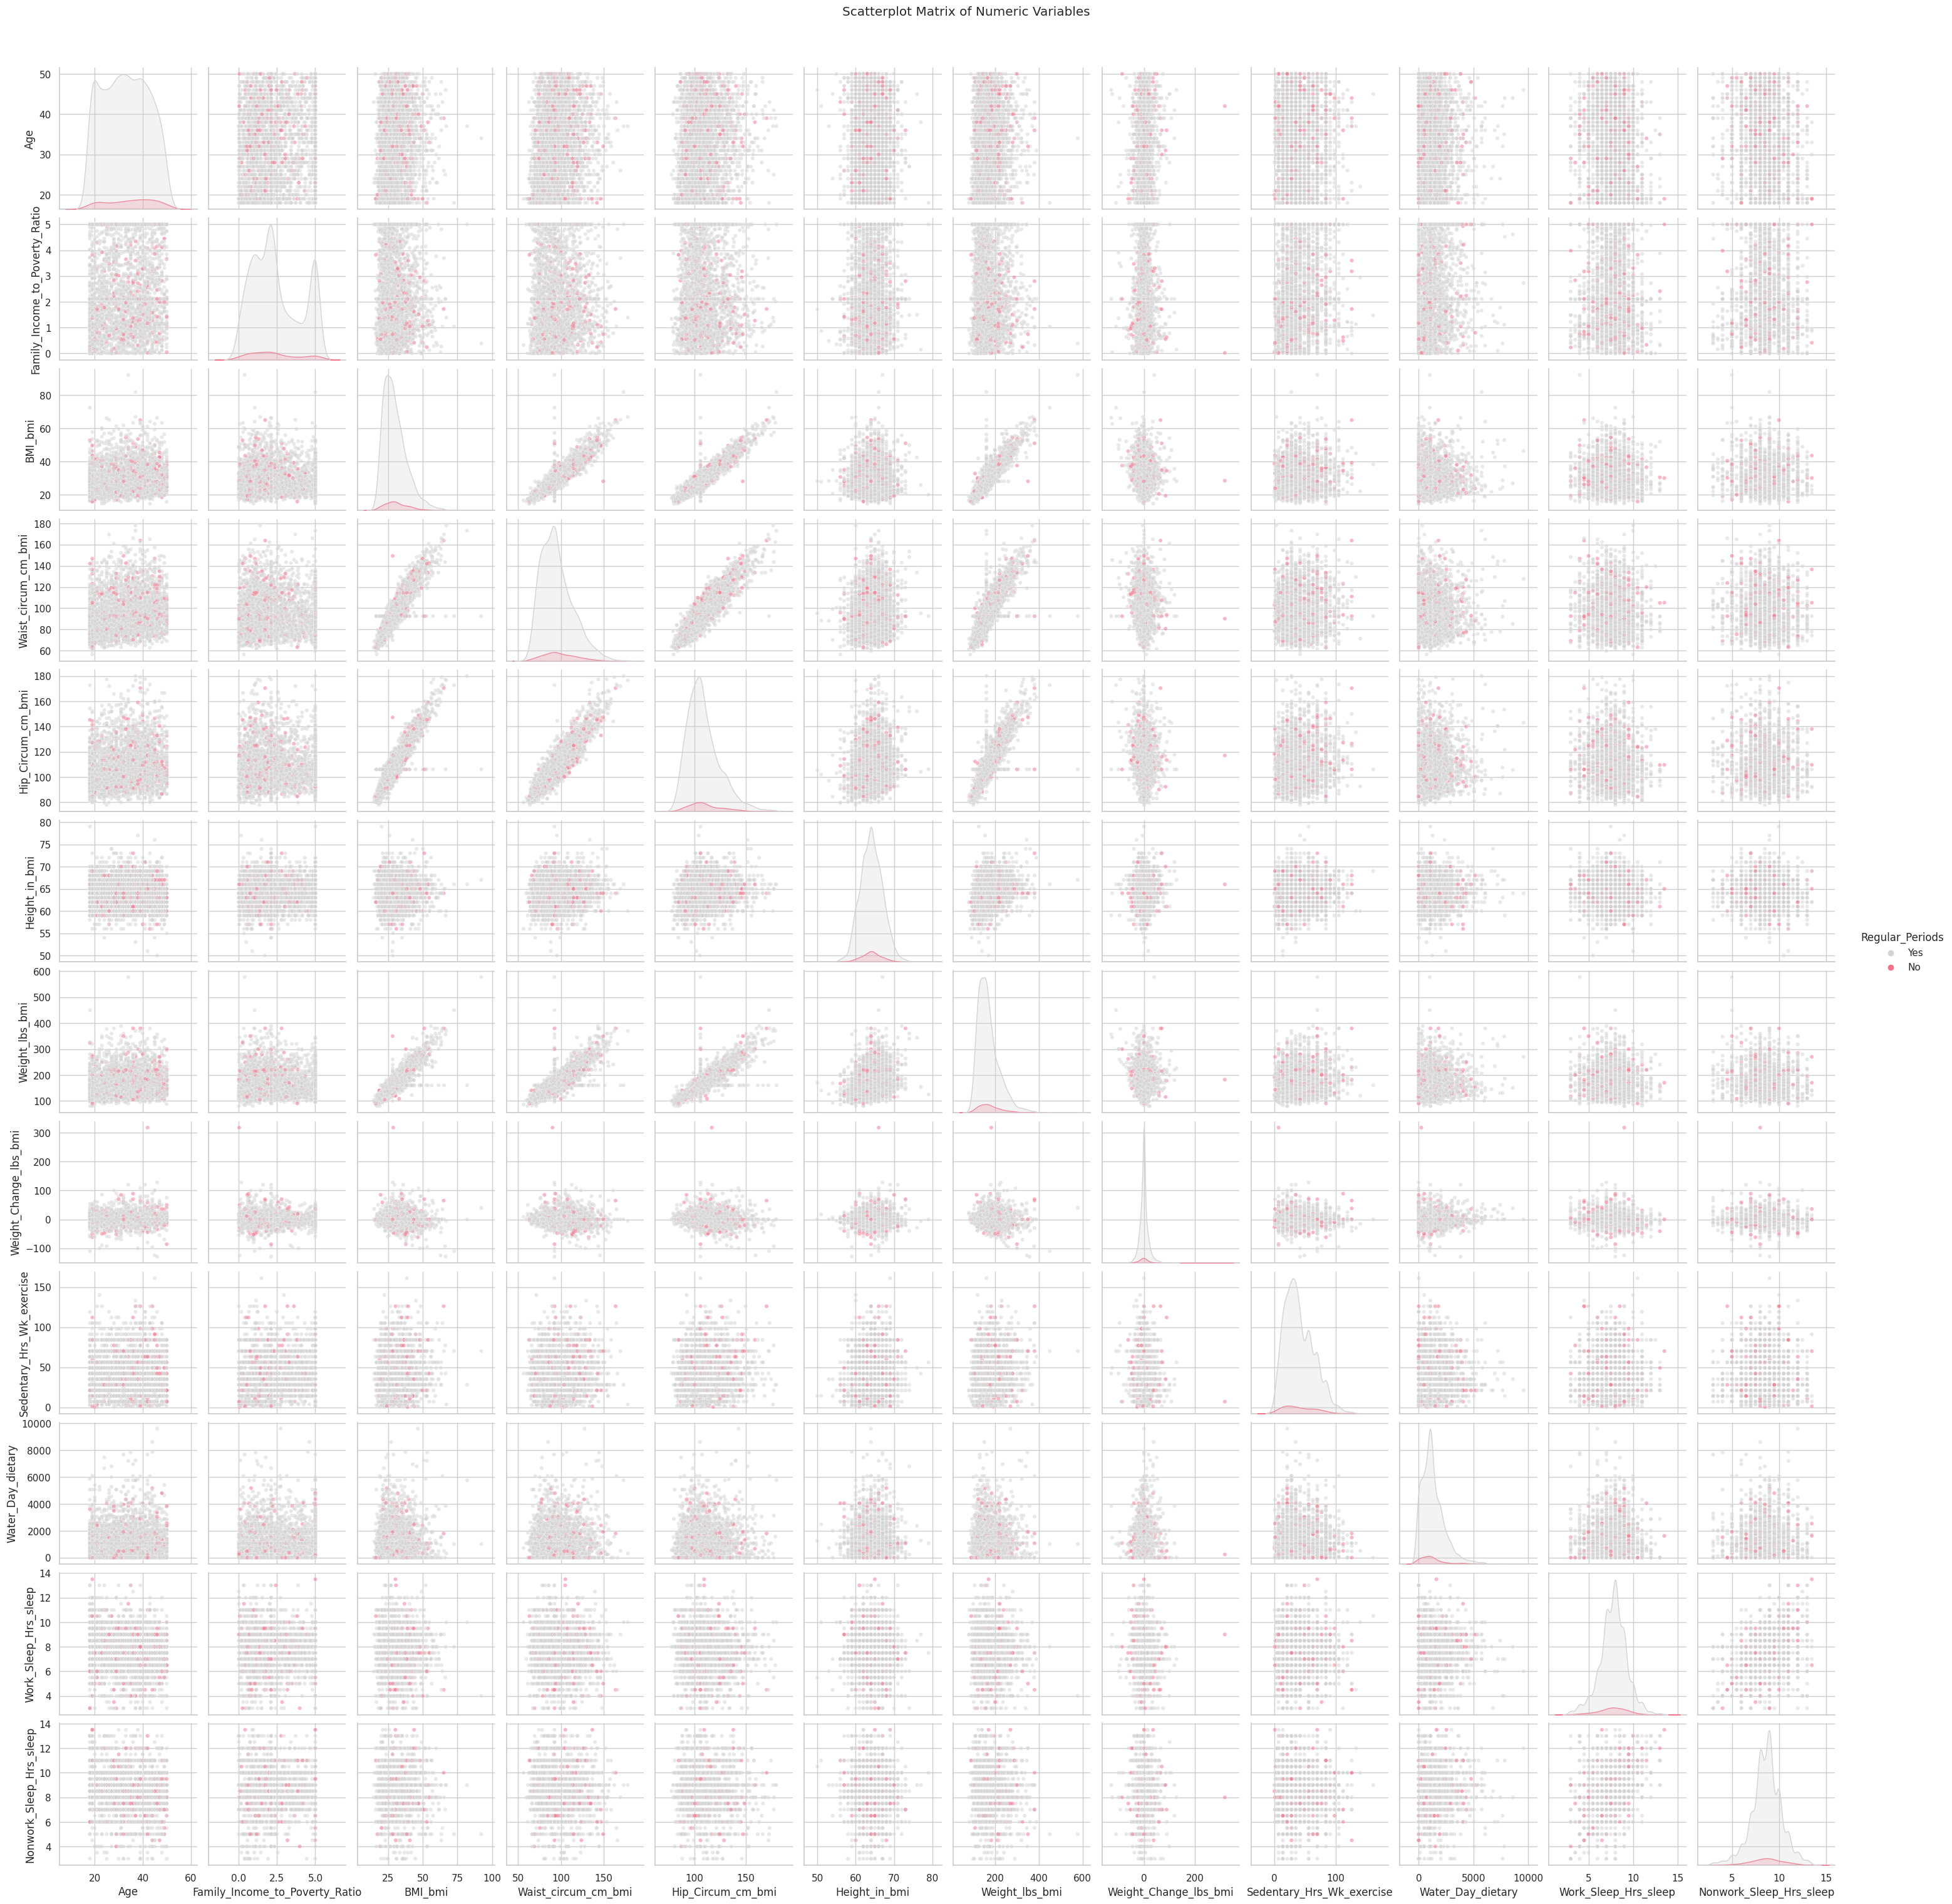

In [2998]:
# Select only numeric columns (exclude participant ID)
numeric_df = cleaned.select_dtypes(include=["int64", "float64"])
numeric_df = numeric_df.drop(columns=["SEQN"])

# Define custom 2-color palette
custom_palette = {
    "Yes": "lightgray",   # regular cycles
    "No": primary_color,      # irregular cycles
}

# Pairplot of numeric variables colored by regular_periods
sns.pairplot(
    numeric_df.join(cleaned["Regular_Periods"]),  # add back outcome for hue
    diag_kind="kde",            # "kde" or "hist" for diagonals
    hue="Regular_Periods",      # color by group
    palette=custom_palette,
    plot_kws={"alpha": 0.5, "s": 20},
)

plt.suptitle("Scatterplot Matrix of Numeric Variables", y=1.02)
plt.show()


### Mann–Whitney U test

In [2999]:
# Map to numeric if not already
cleaned["Regular_Periods"] = cleaned["Regular_Periods"].map({"No": 0, "Yes": 1})

from scipy.stats import pointbiserialr, mannwhitneyu

# ---- Automatically select numeric columns ----
numeric_cols = cleaned.select_dtypes(include=["number"]).columns
numeric_cols = [
    col for col in numeric_cols if col not in ["Regular_Periods", "SEQN"]
]

In [3000]:
# ---- Mann–Whitney U tests with effect size ----
results_m = []

for col in numeric_cols:
    group0 = cleaned.loc[cleaned["Regular_Periods"] == 0, col].dropna()
    group1 = cleaned.loc[cleaned["Regular_Periods"] == 1, col].dropna()

    if len(group0) > 0 and len(group1) > 0:  # avoid empty groups
        stat, p = mannwhitneyu(group0, group1, alternative="two-sided")

        n0, n1 = len(group0), len(group1)
        # Rank-biserial correlation (effect size)
        r_rb = (2 * stat) / (n0 * n1) - 1

        results_m.append(
            {
                "Feature": col,
                "U-statistic": stat,
                "p-value": p,
                "Median_0": group0.median(),
                "Median_1": group1.median(),
                "N_0": n0,
                "N_1": n1,
                "Rank-Biserial_r": r_rb,
            }
        )

# Convert results to DataFrame
mw_df = pd.DataFrame(results_m)

# Keep only significant results (p < 0.05)
mw_df_significant = mw_df[mw_df["p-value"] < 0.05].copy()

# Sort by p-value
mw_df_significant = mw_df_significant.sort_values(by="p-value")

print("\nMann–Whitney U tests (p < 0.05):\n", mw_df_significant)



Mann–Whitney U tests (p < 0.05):
                Feature  U-statistic   p-value  Median_0  Median_1  N_0   N_1  \
3  Waist_circum_cm_bmi     338078.5  0.004728     95.35      92.5  206  2937   
0                  Age     337237.0  0.005788     36.00      33.0  206  2937   
2              BMI_bmi     333686.0  0.013283     29.95      28.2  206  2937   
6       Weight_lbs_bmi     332436.5  0.017434    169.00     160.0  206  2937   
9    Water_Day_dietary     276924.5  0.041795   1072.50    1072.5  206  2937   
4    Hip_Circum_cm_bmi     327360.5  0.048414    107.40     106.0  206  2937   

   Rank-Biserial_r  
3         0.117574  
0         0.114793  
2         0.103054  
6         0.098924  
9        -0.084580  
4         0.082144  


### Outcome

Several variables — including **age, BMI, waist circumference, weight, and hip circumference** — showed statistically significant differences between groups at the 5% level.  
However, all associated effect sizes were small (**rank-biserial correlation, r_rb ≤ 0.12**).  

**Interpretation:**  
While these findings indicate detectable differences, the small effect sizes suggest that the magnitude of these associations is weak. Therefore, results should be interpreted with caution, as statistical significance does not necessarily imply practical or clinical significance.


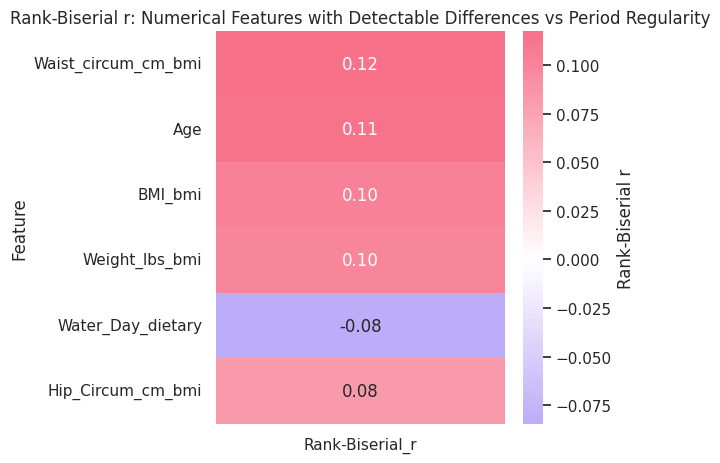

In [3001]:
from matplotlib.colors import LinearSegmentedColormap

# Create a diverging colormap (secondary → white → primary)
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [secondary_color, "white", primary_color],
)

# Prepare heatmap data (Feature vs Rank-Biserial r)
heatmap_data = mw_df_significant.set_index("Feature")[["Rank-Biserial_r"]]

# Plot heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    center=0,
    cbar_kws={"label": "Rank-Biserial r"},
)

plt.title(
    "Rank-Biserial r: Numerical Features with Detectable Differences "
    "vs Period Regularity"
)
plt.ylabel("Feature")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [3002]:
# Extract suffix from feature names (e.g., "BMI_bmi" → "bmi")
mw_df["Group"] = mw_df["Feature"].str.extract(r"_([A-Za-z]+)$")

# Keep the row with the highest Rank-Biserial_r per group
filtered_df = (
    mw_df.loc[mw_df.groupby("Group")["Rank-Biserial_r"].idxmax()]
    .reset_index(drop=True)
)

# Drop row for Family_Income_to_Poverty_Ratio if present
filtered_df = filtered_df[filtered_df["Feature"] != "Family_Income_to_Poverty_Ratio"]

print("Filtered results (highest effect size per group, excluding Family_Income_to_Poverty_Ratio):")
print(filtered_df)

Filtered results (highest effect size per group, excluding Family_Income_to_Poverty_Ratio):
                     Feature  U-statistic   p-value  Median_0  Median_1  N_0  \
1        Waist_circum_cm_bmi     338078.5  0.004728     95.35      92.5  206   
2          Water_Day_dietary     276924.5  0.041795   1072.50    1072.5  206   
3  Sedentary_Hrs_Wk_exercise     303220.5  0.954870     35.00      35.0  206   
4    Nonwork_Sleep_Hrs_sleep     306329.0  0.759188      9.00       9.0  206   

    N_1  Rank-Biserial_r     Group  
1  2937         0.117574       bmi  
2  2937        -0.084580   dietary  
3  2937         0.002345  exercise  
4  2937         0.012621     sleep  


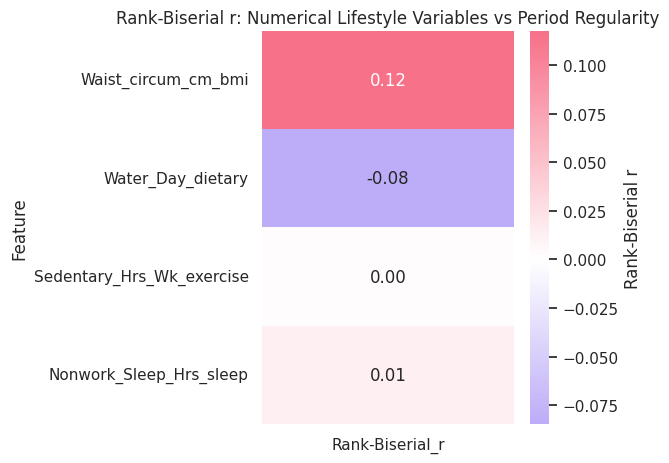

In [3003]:
# Prepare heatmap data (Feature vs Rank-Biserial r)
heatmap_data = filtered_df.set_index("Feature")[["Rank-Biserial_r"]]

# Plot heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    center=0,
    cbar_kws={"label": "Rank-Biserial r"},
)

plt.title(
    "Rank-Biserial r: Numerical Lifestyle Variables vs Period Regularity"
)
plt.ylabel("Feature")
plt.xlabel("")
plt.tight_layout()
plt.show()


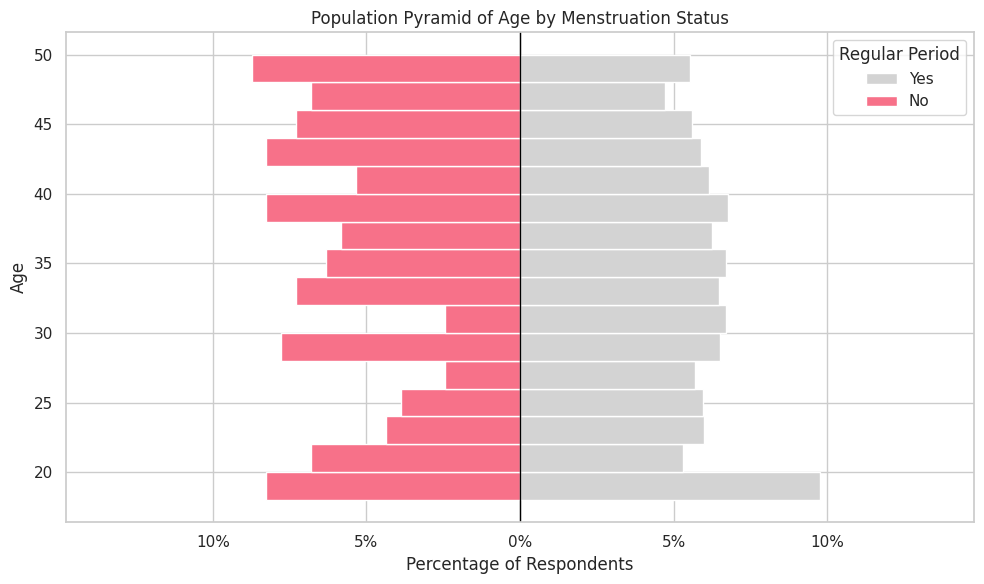

In [3004]:
import matplotlib.ticker as mticker

# Bin the ages
bin_width = 2
bins = range(
    int(cleaned["Age"].min()),
    int(cleaned["Age"].max()) + bin_width,
    bin_width,
)

# Compute histogram data for each group
yes_counts, _ = np.histogram(
    cleaned.loc[cleaned["Regular_Periods"] == 1, "Age"], bins=bins
)
no_counts, _ = np.histogram(
    cleaned.loc[cleaned["Regular_Periods"] == 0, "Age"], bins=bins
)

# Convert to percentages
yes_perc = yes_counts / yes_counts.sum() * 100
no_perc = no_counts / no_counts.sum() * 100

# Midpoints for bin labels
bin_mid = [b + bin_width / 2 for b in bins[:-1]]

# Plot pyramid
plt.figure(figsize=(10, 6))
plt.barh(bin_mid, yes_perc, height=bin_width, color="lightgray", label="Yes")
plt.barh(bin_mid, -no_perc, height=bin_width, color=primary_color, label="No")

# Decorations
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Percentage of Respondents")
plt.ylabel("Age")
plt.title("Population Pyramid of Age by Menstruation Status")

# Find the largest absolute percentage and set symmetric x-axis limits
max_perc = max(yes_perc.max(), no_perc.max())
plt.xlim(-max_perc - 5, max_perc + 5)

# Format x-axis ticks as positive percentages
ax = plt.gca()
ax.xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"{abs(x):.0f}%")
)

plt.legend(title="Regular Period", loc="upper right")
plt.tight_layout()
plt.show()


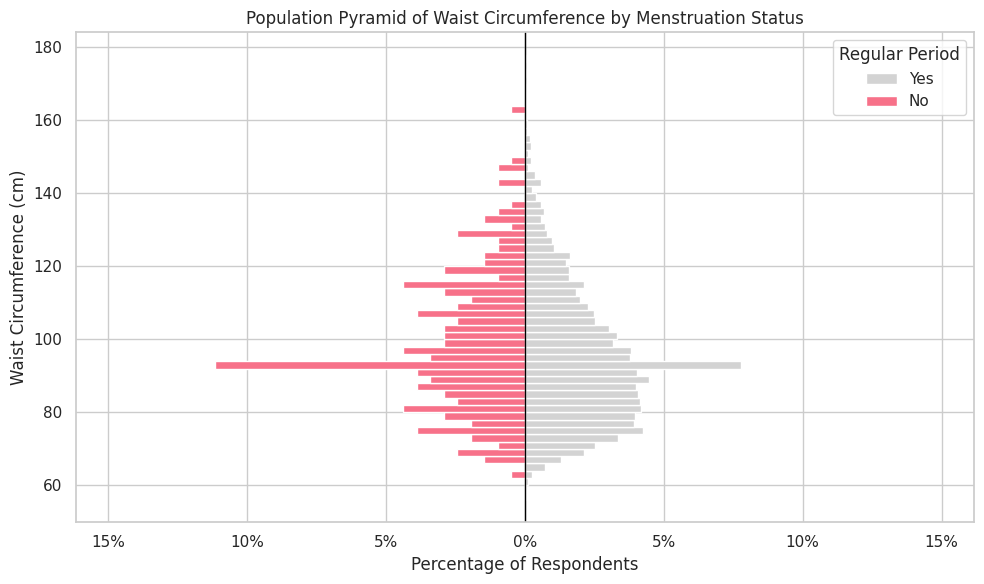

In [3005]:
# Bin the waist circumference
bin_width = 2
bins = range(
    int(cleaned["Waist_circum_cm_bmi"].min()),
    int(cleaned["Waist_circum_cm_bmi"].max()) + bin_width,
    bin_width,
)

# Compute histogram data for each group
yes_counts, _ = np.histogram(
    cleaned.loc[cleaned["Regular_Periods"] == 1, "Waist_circum_cm_bmi"],
    bins=bins,
)
no_counts, _ = np.histogram(
    cleaned.loc[cleaned["Regular_Periods"] == 0, "Waist_circum_cm_bmi"],
    bins=bins,
)

# Convert to percentages
yes_perc = yes_counts / yes_counts.sum() * 100
no_perc = no_counts / no_counts.sum() * 100

# Midpoints for bin labels
bin_mid = [b + bin_width / 2 for b in bins[:-1]]

# Plot pyramid
plt.figure(figsize=(10, 6))
plt.barh(bin_mid, yes_perc, height=bin_width, color="lightgray", label="Yes")
plt.barh(bin_mid, -no_perc, height=bin_width, color=primary_color, label="No")

# Decorations
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Percentage of Respondents")
plt.ylabel("Waist Circumference (cm)")
plt.title("Population Pyramid of Waist Circumference by Menstruation Status")

# Symmetric x-axis limits
max_perc = max(yes_perc.max(), no_perc.max())
plt.xlim(-max_perc - 5, max_perc + 5)

# Format x-axis ticks as positive percentages
ax = plt.gca()
ax.xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"{abs(x):.0f}%")
)

plt.legend(title="Regular Period", loc="upper right")
plt.tight_layout()
plt.show()


## Relationship Between Categorical Variables and Outcome

We investigated associations between categorical predictors and menstrual cycle regularity (`Regular_Periods`) using a stepwise approach:

1. **Statistical Testing (Chi-Square Tests)**  
   - Each categorical variable was first tested against the outcome using a **chi-square test of independence**.  
   - Features with **p < 0.05** were considered to show evidence of association.  
   - Effect size was assessed with **Cramer’s V**, allowing us to prioritize variables with both statistical significance and meaningful association strength.  

2. **Feature Reduction**  
   - Only variables with significant results and interpretable effect sizes were retained for further analysis.  
   - This step reduces noise and ensures subsequent interpretation focuses on the most relevant categorical features.  

3. **Visualization (Contingency Tables & Stacked Bar Charts)**  
   - For the reduced set of features, we created **contingency tables** to summarize group distributions.  
   - To aid interpretation, we plotted **stacked bar charts** comparing the proportions of women with regular vs. irregular cycles across categories.  
   - This visualization highlights relative differences and makes patterns of association more intuitive.  


In [3015]:
# Select categorical columns
categorical_cols = cleaned.select_dtypes(include=["object", "category"]).columns

categorical_cols

Index(['Race', 'Education', 'Attempted_Weight_Loss_bmi', 'Smoked_100_smoking',
       'Household_Smoker_Count_smoking', 'Alc_Freq_alcohol',
       'Daily_Drinks_alcohol', 'Salt_Used_dietary', 'On_Diet_dietary',
       'Dietary_Supp_dietary', 'Work_Sleep_Time_Category_sleep',
       'Work_Wake_Time_Category_sleep', 'Work_Sleep_Hrs_Category_sleep',
       'Nonwork_Sleep_Time_Category_sleep', 'Nonwork_Wake_Time_Category_sleep',
       'Nonwork_Sleep_Hrs_Category_sleep'],
      dtype='object')

### Chi-Square Test of Independence  
#### Cramer’s V Heatmap  

- The analysis begins with a **chi-square test of independence**, which evaluates whether the distribution of a categorical variable differs across groups of the outcome (`Regular_Periods`).  
- To quantify the strength of these associations, we calculate **Cramer’s V** for each variable.  
- **Cramer’s V**:  
  - Derived directly from the chi-square statistic.  
  - Measures the strength (not the direction) of association between two categorical variables.  
  - Values range from **0 (no association)** to **1 (perfect association)**.  
- Results are visualized using a **heatmap of Cramer’s V values**, making it easier to compare effect sizes across categorical predictors.  


In [3016]:
from scipy.stats import chi2_contingency

def cramers_v(chi2, n, r, c):
    """Standard Cramér's V."""
    denom = n * (min(r - 1, c - 1))
    return np.sqrt(chi2 / denom) if denom > 0 else np.nan


def cramers_v_bias_corrected(chi2, n, r, c):
    """
    Bias-corrected Cramér's V (Bergsma & Wicher, 2013).
    More reliable with small samples or imbalanced tables.
    """
    if n <= 1:
        return np.nan
    phi2 = chi2 / n
    phi2_corr = max(0.0, phi2 - ((c - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    c_corr = c - ((c - 1) ** 2) / (n - 1)
    denom = min(r_corr - 1, c_corr - 1)
    return np.sqrt(phi2_corr / denom) if denom > 0 else np.nan


def v_label(v):
    """Quick interpretation labels for Cramér’s V."""
    if np.isnan(v):
        return "n/a"
    if v < 0.10:
        return "negligible"
    if v < 0.30:
        return "small"
    if v < 0.50:
        return "medium"
    return "large"


cat_results = []

for col in categorical_cols:
    contingency = pd.crosstab(cleaned["Regular_Periods"], cleaned[col])
    chi2, p_chi2, dof, expected = chi2_contingency(contingency)

    r, c = contingency.shape
    n = contingency.values.sum()

    v = cramers_v(chi2, n, r, c)
    v_bc = cramers_v_bias_corrected(chi2, n, r, c)

    cat_results.append(
        {
            "Feature": col,
            "Rows": r,
            "Cols": c,
            "Chi2": chi2,
            "Chi2_p": p_chi2,
            "CramersV": v,
            "CramersV_biascorr": v_bc,
            "EffectSize": v_label(v_bc if not np.isnan(v_bc) else v),
        }
    )

cat_corr_df = pd.DataFrame(cat_results).sort_values("Chi2_p")
sig_results = cat_corr_df[cat_corr_df["Chi2_p"] < 0.05].sort_values("Chi2_p")

print("Chi-square test of independence with effect size labels:\n", sig_results)


Chi-square test of independence with effect size labels:
                               Feature  Rows  Cols       Chi2    Chi2_p  \
0                                Race     2     6  19.280819  0.001704   
1                           Education     2     5  14.948211  0.004810   
3                  Smoked_100_smoking     2     2   5.585656  0.018108   
7                   Salt_Used_dietary     2     4   9.761126  0.020710   
10     Work_Sleep_Time_Category_sleep     2     2   4.661779  0.030841   
13  Nonwork_Sleep_Time_Category_sleep     2     2   4.661779  0.030841   
11      Work_Wake_Time_Category_sleep     2     3   6.858437  0.032412   
4      Household_Smoker_Count_smoking     2     3   6.173033  0.045661   

    CramersV  CramersV_biascorr  EffectSize  
0   0.078323           0.067414  negligible  
1   0.068964           0.059026  negligible  
3   0.042157           0.038202  negligible  
7   0.055729           0.046385  negligible  
10  0.038513           0.034137  negligible  

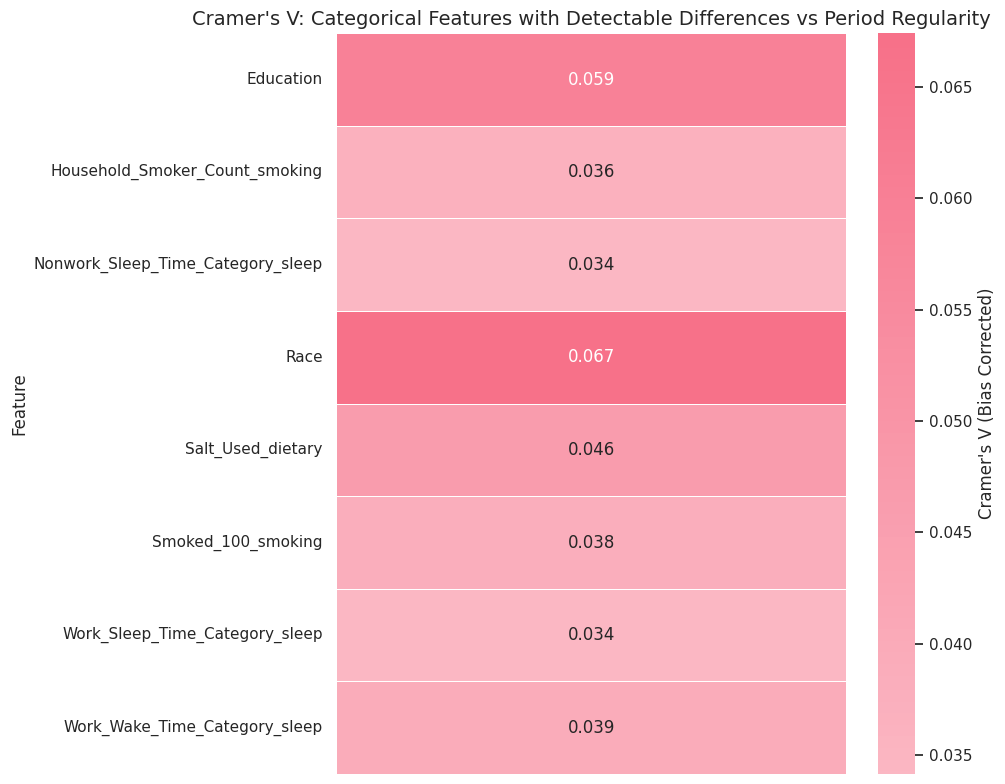

In [3020]:
# Pivot the DataFrame to make a heatmap-ready matrix
heatmap_data = sig_results.pivot(
    index="Feature",
    columns="Rows",
    values="CramersV_biascorr",
)

# If 'Rows' isn’t what you want for columns, you could instead pivot against 'Cols'
# depending on how your chi-square loop was structured.
# Example: columns="Cols"

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    annot=True,  # show the numeric values
    cmap=custom_cmap,  # custom diverging colormap
    center=0,  # center colormap
    linewidths=0.5,
    cbar_kws={"label": "Cramer's V (Bias Corrected)"},
)

plt.title(
    "Cramer's V: Categorical Features with Detectable Differences "
    "vs Period Regularity",
    fontsize=14,
)
plt.ylabel("Feature")
plt.xticks([])  # remove the x-axis ticks
plt.xlabel("")  # remove the x-axis label
plt.tight_layout()
plt.show()


In [3024]:
# Extract suffix from feature names (e.g., "Race_demo" → "demo")
sig_results["Group"] = sig_results["Feature"].str.extract(r"_([A-Za-z]+)$")

# Keep the row with the highest Cramér’s V (bias corrected) per group
filtered_cat_df = (
    sig_results.loc[sig_results.groupby("Group")["CramersV_biascorr"].idxmax()]
    .reset_index(drop=True)
)


print(
    "Filtered categorical results (highest effect size per group, "
    "excluding Family_Income_to_Poverty_Ratio):"
)
print(filtered_cat_df)


Filtered categorical results (highest effect size per group, excluding Family_Income_to_Poverty_Ratio):
                         Feature  Rows  Cols      Chi2    Chi2_p  CramersV  \
0              Salt_Used_dietary     2     4  9.761126  0.020710  0.055729   
1  Work_Wake_Time_Category_sleep     2     3  6.858437  0.032412  0.046713   
2             Smoked_100_smoking     2     2  5.585656  0.018108  0.042157   

   CramersV_biascorr  EffectSize    Group  
0           0.046385  negligible  dietary  
1           0.039320  negligible    sleep  
2           0.038202  negligible  smoking  


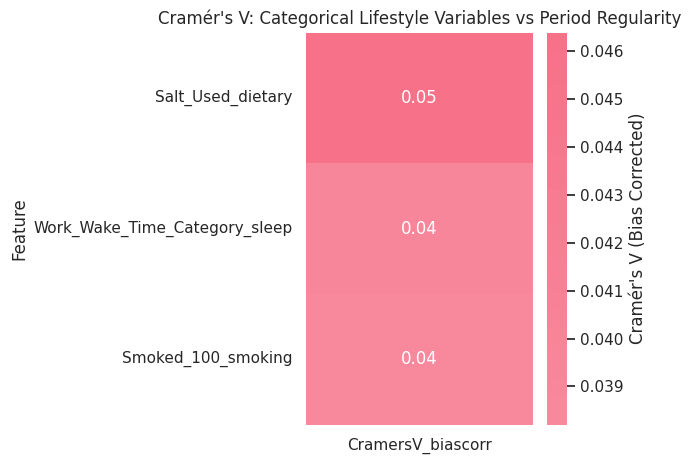

In [3025]:
# Prepare heatmap data (Feature vs Cramér's V bias corrected)
heatmap_data = filtered_cat_df.set_index("Feature")[["CramersV_biascorr"]]

# Plot heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    center=0,
    cbar_kws={"label": "Cramér's V (Bias Corrected)"},
)

plt.title(
    "Cramér's V: Categorical Lifestyle Variables vs Period Regularity"
)
plt.ylabel("Feature")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [3026]:
def plot_stacked_bars_all(df, target, features, normalize=True):
    """
    Loop through a list of categorical features and plot stacked bar charts vs a target.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Dataset
    target : str
        Column to use as x-axis (e.g. "Regular_Periods_demo")
    features : list or Series
        List of categorical feature names to plot
    normalize : bool, default=True
        If True, bars show row percentages (each bar sums to 100)
    palette : str or list, default="Set2"
        Colormap or list of colors
    """
    
    results = {}
    
    for col in features:
        # contingency table
        ct = pd.crosstab(
            df[target],
            df[col],
            normalize="index" if normalize else False
        )
        if normalize:
            ct = ct * 100
        results[col] = ct

        # plot stacked bar chart
        ax = ct.plot(
            kind="bar",
            stacked=True,
            figsize=(16,8)
        )

        plt.title(f"{col} by {target} ({'%' if normalize else 'Counts'})")
        plt.xlabel(target)
        plt.ylabel("Percentage (%)" if normalize else "Count")
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.grid(axis="y", linestyle="--")
        plt.tight_layout()
        plt.show()
    
    return results


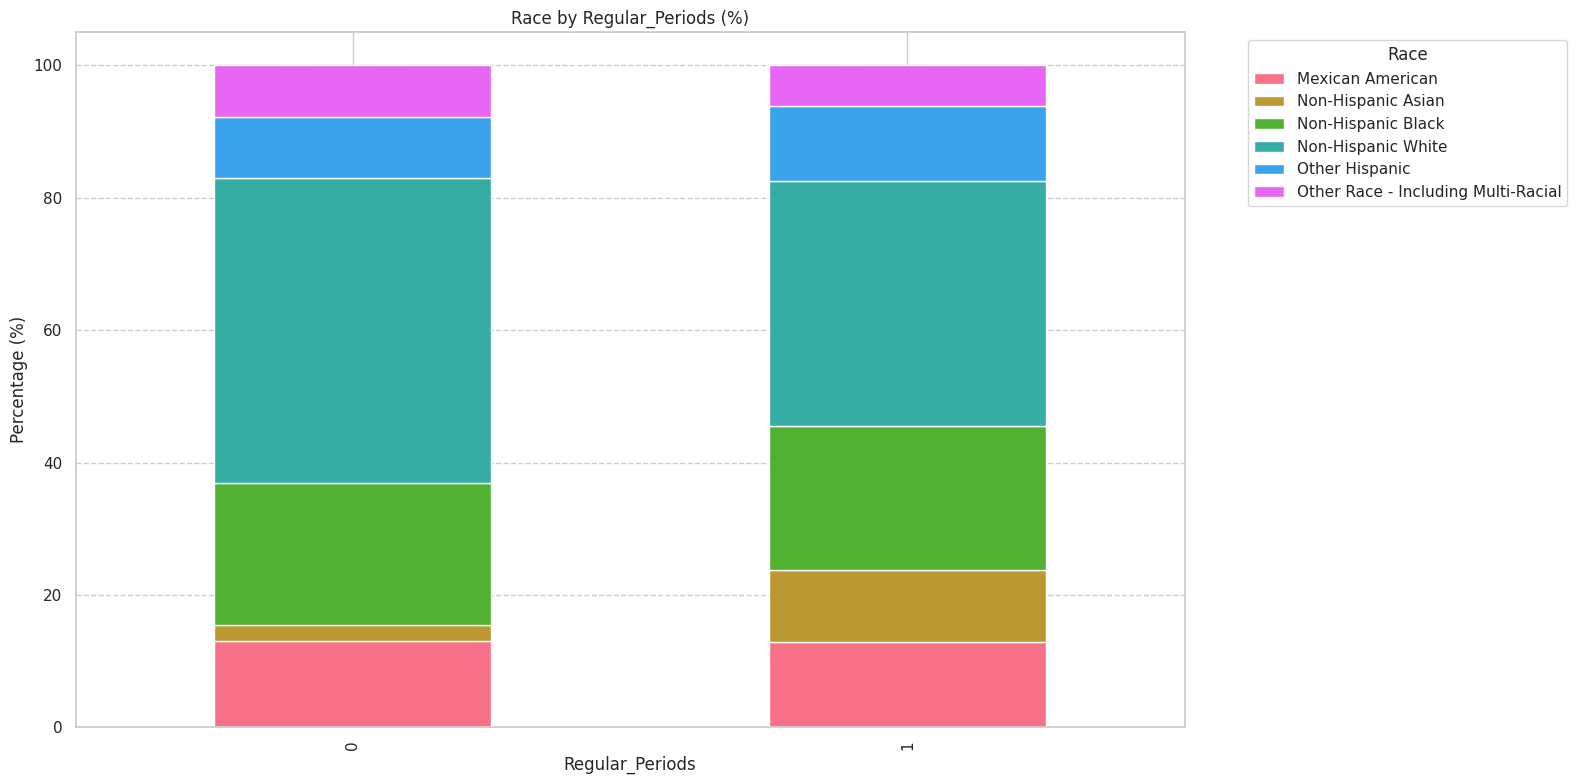

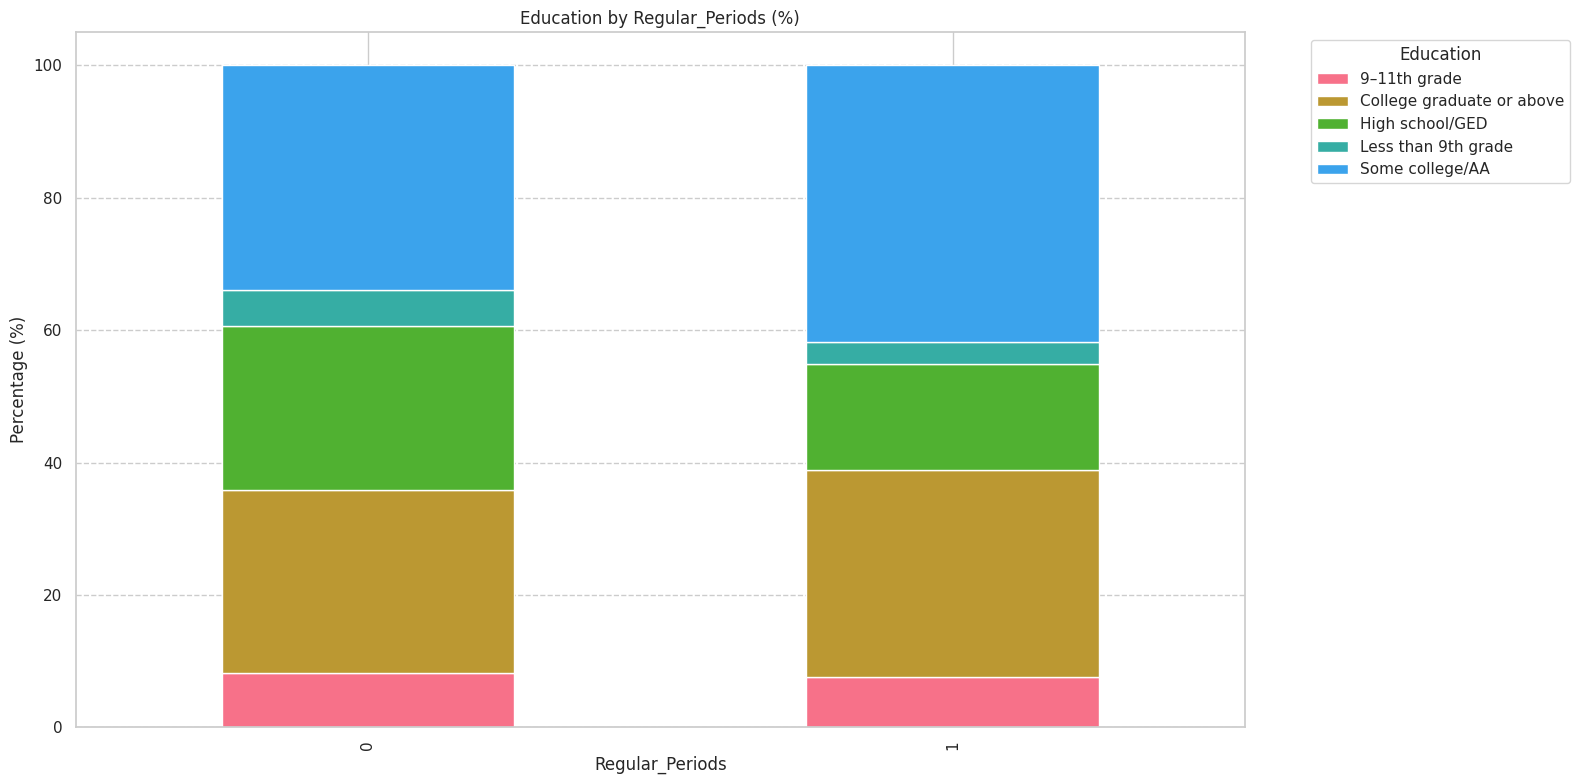

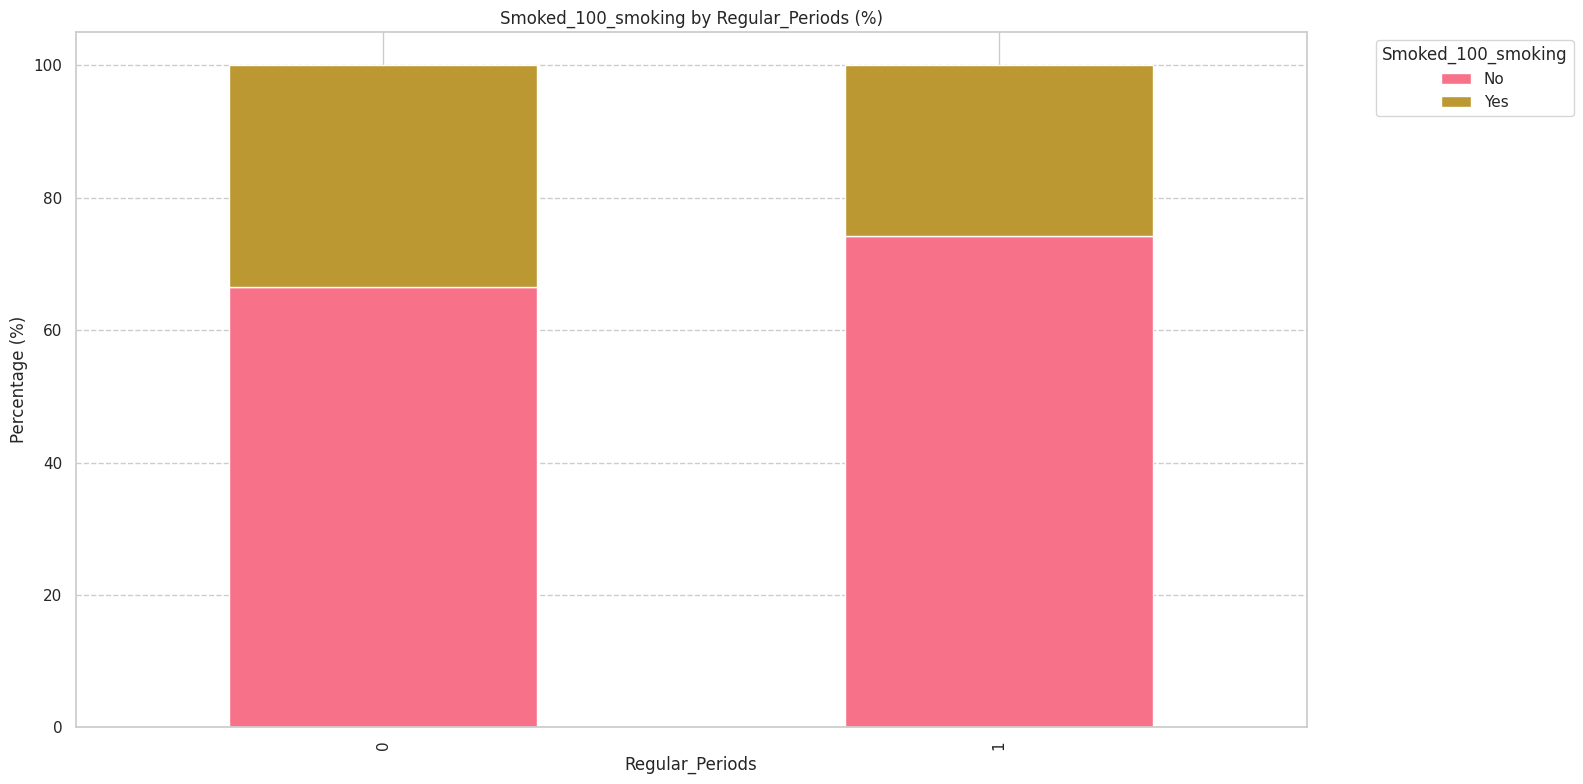

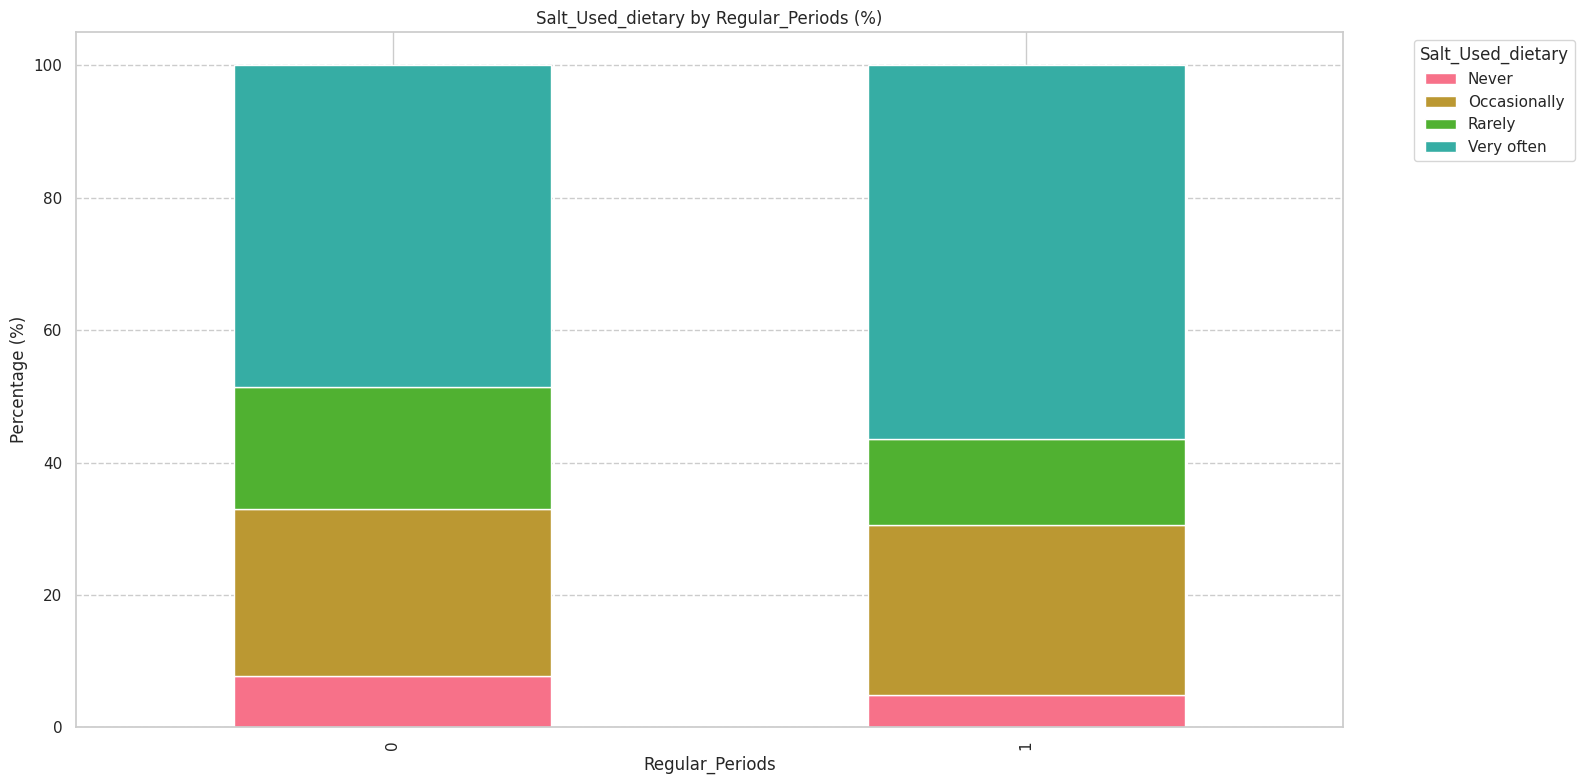

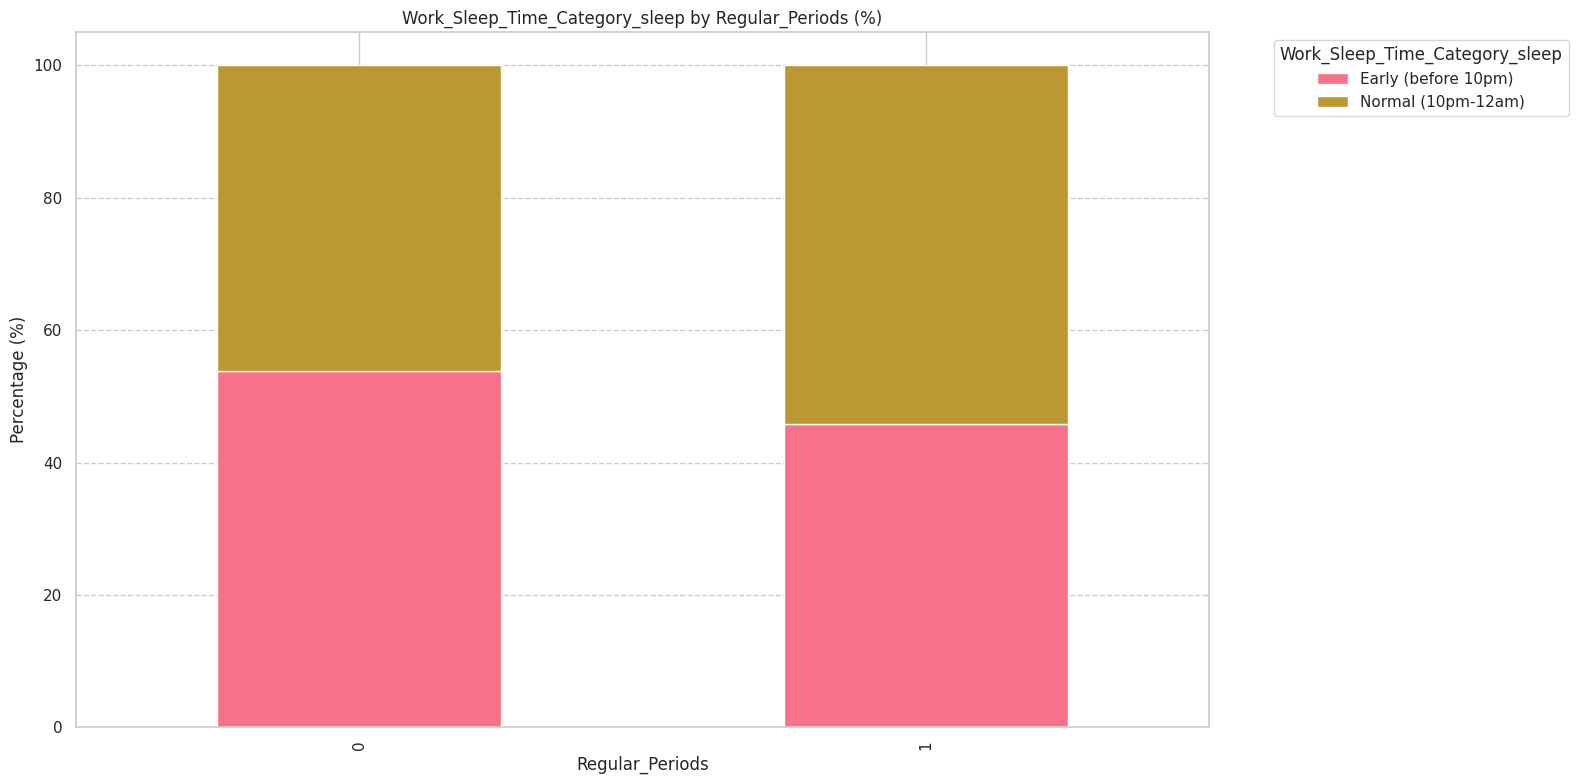

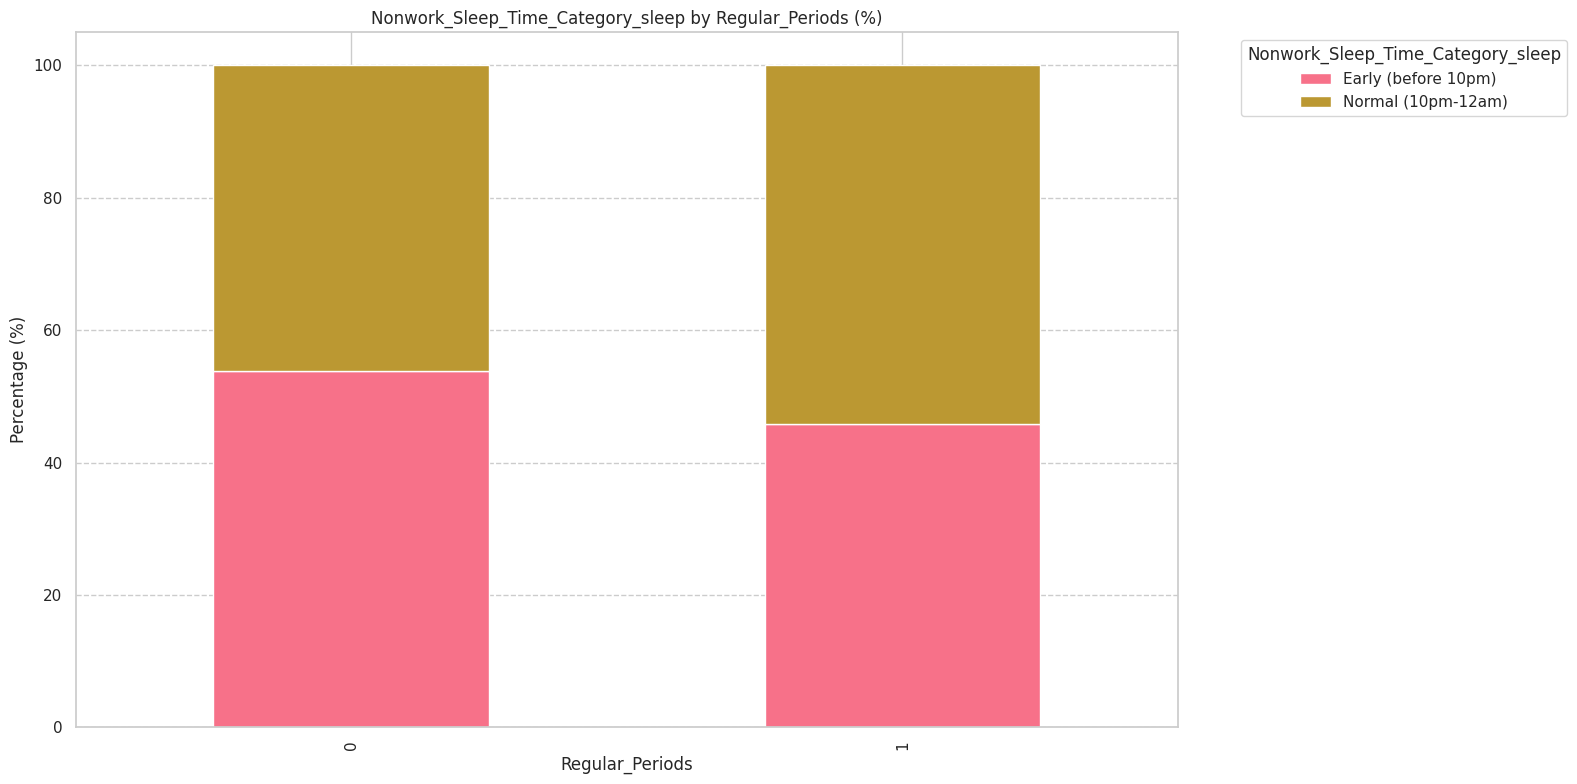

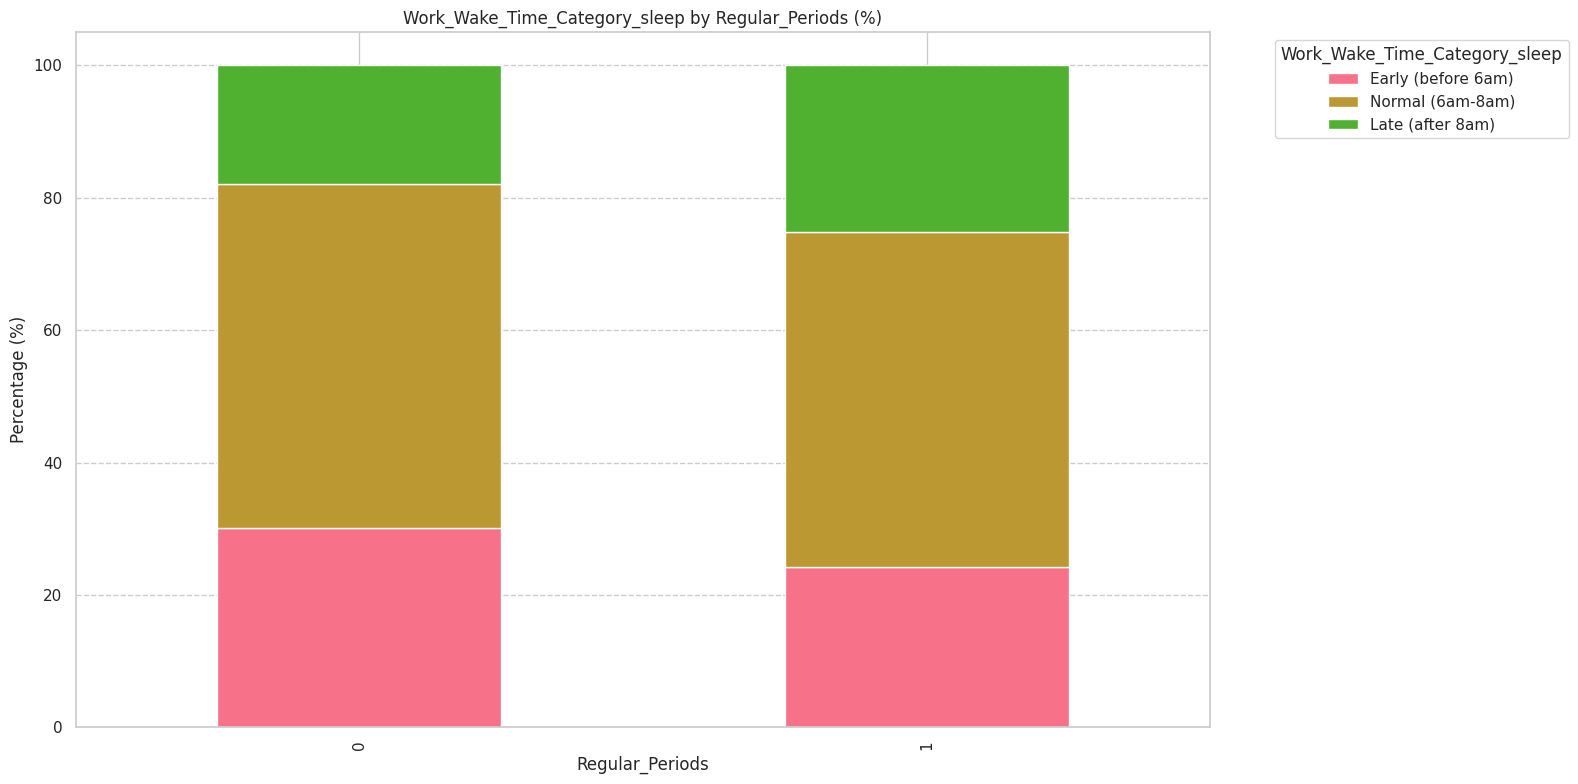

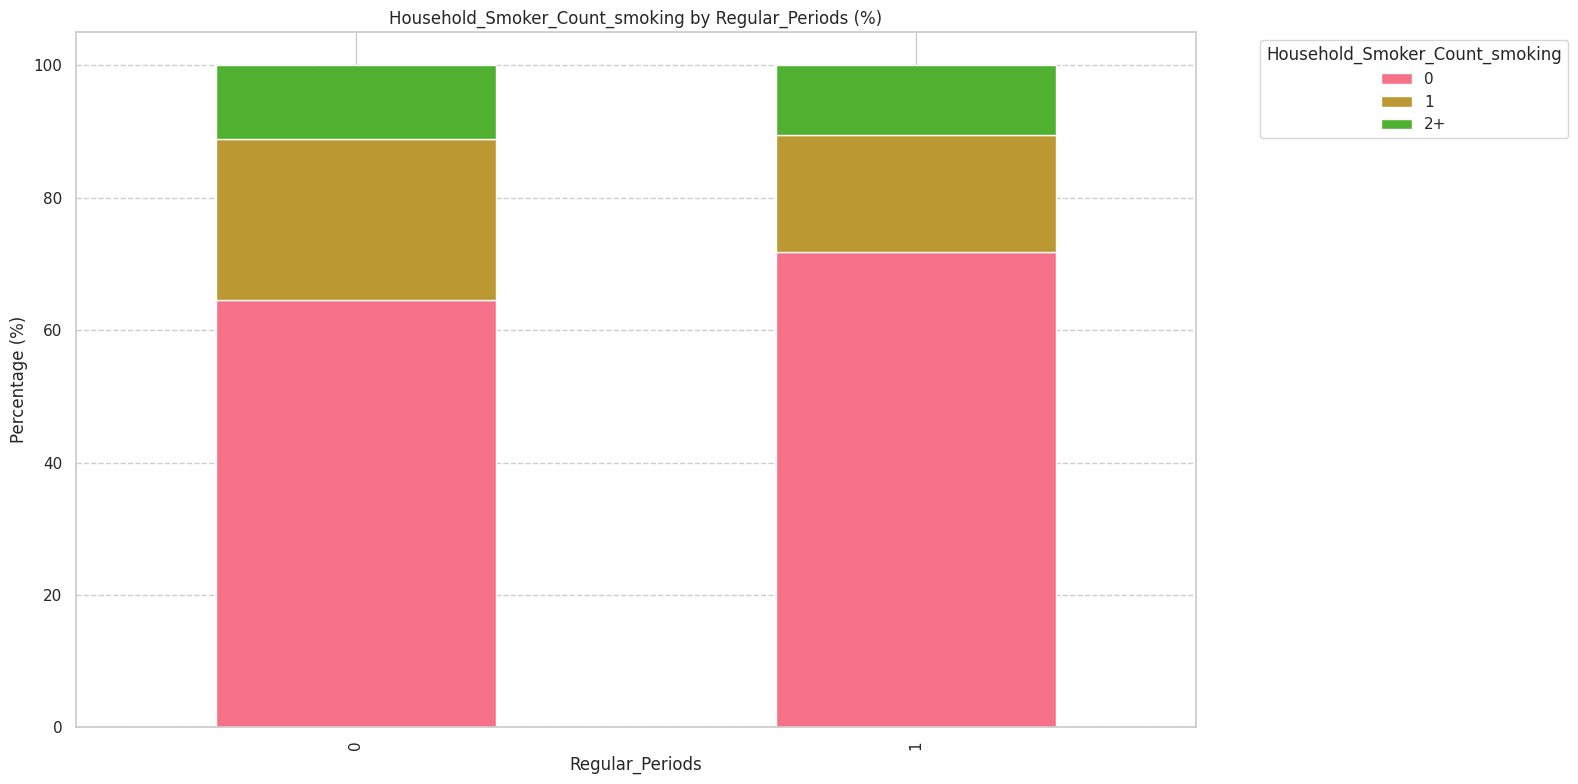

{'Race': Race             Mexican American  Non-Hispanic Asian  Non-Hispanic Black  \
 Regular_Periods                                                             
 0                       13.106796            2.427184           21.359223   
 1                       12.870276           10.827375           21.893088   
 
 Race             Non-Hispanic White  Other Hispanic  \
 Regular_Periods                                       
 0                         46.116505        9.223301   
 1                         36.874362       11.406197   
 
 Race             Other Race - Including Multi-Racial  
 Regular_Periods                                       
 0                                           7.766990  
 1                                           6.128703  ,
 'Education': Education        9–11th grade  College graduate or above  High school/GED  \
 Regular_Periods                                                             
 0                    8.252427                  27.669903 

In [3027]:
categorical_vars = sig_results['Feature']
plot_stacked_bars_all(cleaned, "Regular_Periods", categorical_vars)

## Results  

Several categorical variables — including **race, education, smoking history, salt use, and sleep timing** — showed statistically significant associations with menstrual regularity (*p* < 0.05, chi-square test).  

However, the effect sizes were consistently **negligible** (bias-corrected Cramér’s V ≤ 0.07). This indicates that, although the associations are statistically detectable given the sample size, their **practical importance is weak** and should be interpreted with caution.  


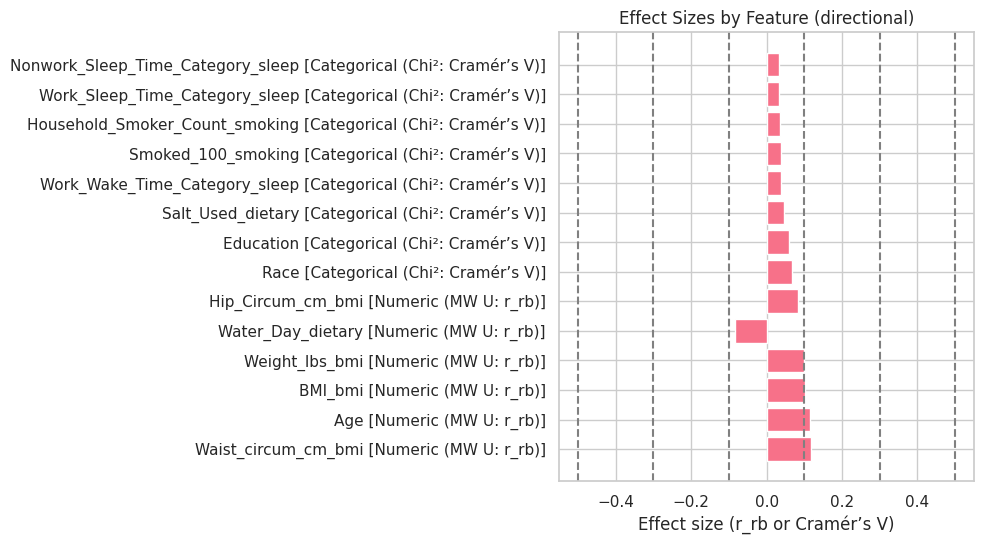

In [3031]:
# --- Assumptions ---
# You already have:
#   mw_df with columns: ['Feature','p-value','Rank-Biserial_r', ...]
#   cat_corr_df with columns: ['Feature','Chi2_p','CramersV_biascorr', ...]
# If your column names differ, tweak below accordingly.

# ------- Build a unified effect-size table -------
num_eff = mw_df[['Feature', 'Rank-Biserial_r', 'p-value']].copy()
num_eff.rename(columns={'Rank-Biserial_r': 'Effect', 'p-value': 'p'}, inplace=True)
num_eff['Type'] = 'Numeric (MW U: r_rb)'

cat_eff = cat_corr_df[['Feature', 'CramersV_biascorr', 'Chi2_p']].copy()
cat_eff.rename(columns={'CramersV_biascorr': 'Effect', 'Chi2_p': 'p'}, inplace=True)
cat_eff['Type'] = 'Categorical (Chi²: Cramér’s V)'

eff_all = pd.concat([num_eff, cat_eff], ignore_index=True)

# Optional: keep only significant effects (comment out to show all)
sig_only = True
if sig_only:
    eff_all = eff_all[eff_all['p'] < 0.05].copy()

# Compute |effect| for sorting/plotting
eff_all['AbsEffect'] = eff_all['Effect'].abs()

# Sort by absolute effect size (largest first)
eff_all = eff_all.sort_values('AbsEffect', ascending=False)

# If nothing passes the filter, short-circuit gracefully
if eff_all.empty:
    print("No effects to plot with current filter (e.g., p < 0.05). Consider setting sig_only=False.")
else:
    # ------- Plot: horizontal bar chart of effect sizes -------
    plt.figure(figsize=(10, max(4, 0.4 * len(eff_all))))

    # Bar positions and labels
    y_pos = np.arange(len(eff_all))
    # Plot signed effects so direction is visible; you can switch to AbsEffect if you prefer
    plt.barh(y_pos, eff_all['Effect'])

    # Y tick labels show feature and (type)
    y_labels = [f"{f} [{t}]" for f, t in zip(eff_all['Feature'], eff_all['Type'])]
    plt.yticks(y_pos, y_labels)

    # Reference thresholds (negligible/small/medium/large)
    for thr in (0.10, 0.30, 0.50):
        plt.axvline(x=thr, linestyle='--', color ='gray')
        plt.axvline(x=-thr, linestyle='--',color='gray')

    plt.xlabel('Effect size (r_rb or Cramér’s V)')
    plt.title('Effect Sizes by Feature (directional)')

    plt.tight_layout()
    plt.show()


Notes

- Direction: For Mann–Whitney, the sign of r_rb indicates which group tends higher (positive ≈ group 0 higher; negative ≈ group 1 higher). Cramér’s V is non-directional by definition; it will just appear non-negative—keeping signs allows the numeric effects to show direction while categorical remain ≥0.

- Thresholds: Vertical dashed lines at 0.10 / 0.30 / 0.50 give quick “negligible/small/medium/large” cues.

- Significance filter: Set sig_only=False to show all effects (often helpful when everything’s small, so readers see “no signal”).

## Can my data predict the outcome?

 - Which variables are most strongly associated with the outcome? (Logistic Models)

In [3032]:
model_data = cleaned.drop([
    'SEQN'
], axis=1)

In [3043]:
# Combine numeric + categorical effects
effects = pd.concat([num_eff, cat_eff], ignore_index=True)

# Filter only statistically significant features
sig_effects = effects[effects['p'] < 0.05]

# Get the list of feature names you want to keep
selected_features = sig_effects['Feature'].unique().tolist()

# Create model_data with only those features + your target column
model_data = cleaned[selected_features + ['Regular_Periods']]


In [3044]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# ==== 1) Target / features ====
TARGET = "Regular_Periods"   # change if needed

# If your target is text, make it 0/1 once (safe if already 0/1).
y = (
    model_data[TARGET]
    .replace({"Yes":1, "No":0, "Y":1, "N":0, True:1, False:0})
    .astype(int)
)

X_raw = model_data.drop(columns=[TARGET])

# ==== 2) Encode categoricals only (no imputation) ====
# get_dummies will leave numeric columns untouched and expand object/category columns.
X = pd.get_dummies(X_raw, drop_first=False)  # keep all dummies; no leakage

# (Optional) if you have boolean columns left, make them 0/1
for c in X.columns:
    if X[c].dtype == bool:
        X[c] = X[c].astype(int)

# ==== 3) Split ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ==== 4) Fit balanced logistic regression ====
logreg = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    solver="liblinear",
    penalty="l2",
    random_state=42,
)

logreg.fit(X_train, y_train)

# ==== 5) Evaluate ====
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

print(f"accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"recall   : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"f1       : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"roc_auc  : {roc_auc_score(y_test, y_prob):.4f}")
print("confusion:\n", confusion_matrix(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred, zero_division=0))


accuracy : 0.6120
precision: 0.9516
recall   : 0.6158
f1       : 0.7477
roc_auc  : 0.6470
confusion:
 [[ 29  23]
 [282 452]]

report:
               precision    recall  f1-score   support

           0       0.09      0.56      0.16        52
           1       0.95      0.62      0.75       734

    accuracy                           0.61       786
   macro avg       0.52      0.59      0.45       786
weighted avg       0.89      0.61      0.71       786



### Summary
With class weighting, the logistic regression improved recall for the minority class (0) from ~46% to 56%, meaning it identified more of the rare cases. However, precision for class 0 remains very low (10%), leading to many false positives. The majority class (1) continues to dominate model performance (F1 = 0.76), and the overall accuracy is 62%. This indicates the logistic regression model still cannot predict the outcome well, especially for the minority class.

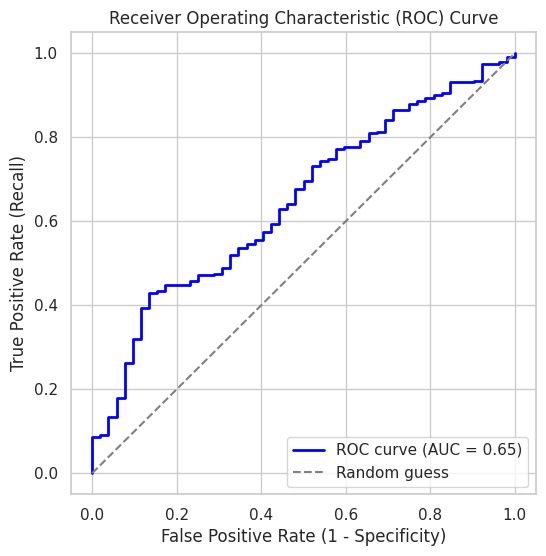

In [3045]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# get predicted probabilities for the positive class (1)
y_prob = logreg.predict_proba(X_test)[:, 1]

# compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# compute ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)

# plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", linewidth=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="gray", linestyle="--", label="Random guess")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


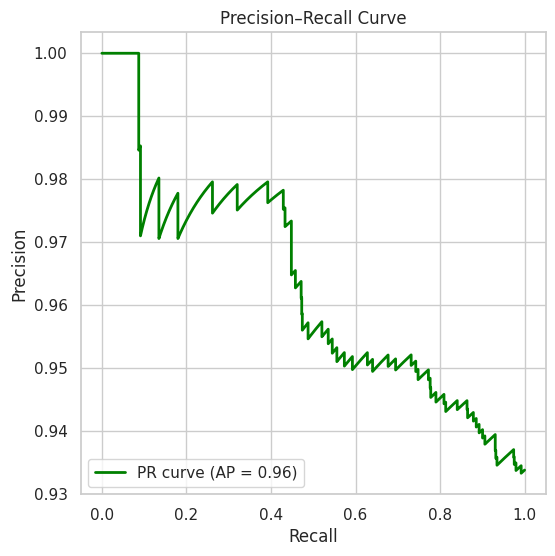

In [3046]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# predicted probabilities for the positive class
y_prob = logreg.predict_proba(X_test)[:, 1]

# precision, recall at various thresholds
prec, rec, thresholds = precision_recall_curve(y_test, y_prob)

# average precision (area under PR curve)
ap = average_precision_score(y_test, y_prob)

# plot
plt.figure(figsize=(6,6))
plt.plot(rec, prec, color="green", linewidth=2, label=f"PR curve (AP = {ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")
plt.show()


### Summary 

We applied logistic regression to test whether the available features could predict the outcome. Visualizations such as the ROC curve (AUC ≈ 0.65) and the Precision–Recall curve confirm that the model’s ability to discriminate is weak. The confusion matrix shows strong bias toward the majority class, while feature odds ratios suggest some associations but insufficient predictive power. Overall, logistic regression reveals that the current feature set does not predict the outcome reliably.

In [3038]:
import numpy as np
import pandas as pd

# Get coefficients and feature names
coef = logreg.coef_[0]             # coefficients for class=1
features = X_train.columns

# Put into DataFrame
odds_df = pd.DataFrame({
    "feature": features,
    "coef": coef,
    "odds_ratio": np.exp(coef)
}).sort_values("odds_ratio", ascending=False)

print(odds_df.head(10))   # top increasing odds
print(odds_df.tail(10))   # top decreasing odds


                                              feature      coef  odds_ratio
13                            Race_Non-Hispanic Asian  1.054034    2.869202
47                           Daily_Drinks_alcohol_7.0  1.012237    2.751750
50                          Daily_Drinks_alcohol_10.0  0.981980    2.669738
39                  Alc_Freq_alcohol_Nearly Every Day  0.916302    2.500028
75  Nonwork_Wake_Time_Category_sleep_Normal (6am-8am)  0.697806    2.009339
53                           Daily_Drinks_alcohol_15+  0.590389    1.804691
45                           Daily_Drinks_alcohol_5.0  0.480878    1.617493
40                             Alc_Freq_alcohol_Never  0.353695    1.424320
22                          Education_Some college/AA  0.350666    1.420013
19                Education_College graduate or above  0.312633    1.367020
                                              feature      coef  odds_ratio
17           Race_Other Race - Including Multi-Racial -0.373288    0.688467
44          

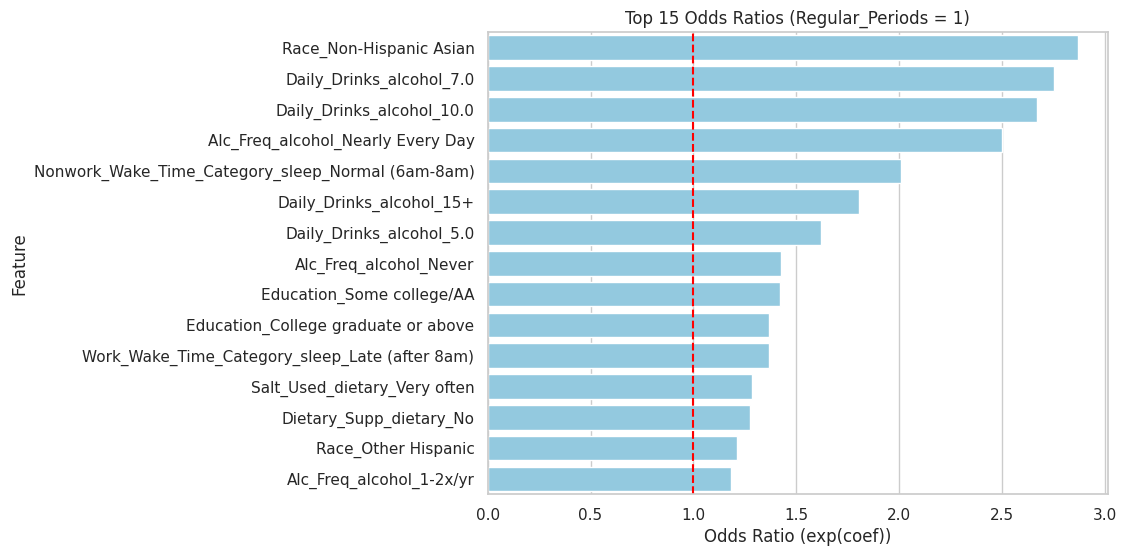

In [3039]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(
    data=odds_df.sort_values("odds_ratio", ascending=False).head(15),
    x="odds_ratio", y="feature", color="skyblue"
)
plt.axvline(1, color="red", linestyle="--")
plt.title("Top 15 Odds Ratios (Regular_Periods = 1)")
plt.xlabel("Odds Ratio (exp(coef))")
plt.ylabel("Feature")
plt.show()


Features with bars to the right of 1 increase the odds of regular periods.

Features to the left of 1 (if you plot the bottom tail) decrease the odds.

The further from 1, the stronger the effect.

How to interpret it:

- Exercise_Yes: odds ratio = 2.3 → exercising is associated with ~2.3× higher odds of regular periods compared to not exercising.

- Age_demo: odds ratio = 1.05 → each additional year increases odds by ~5%.

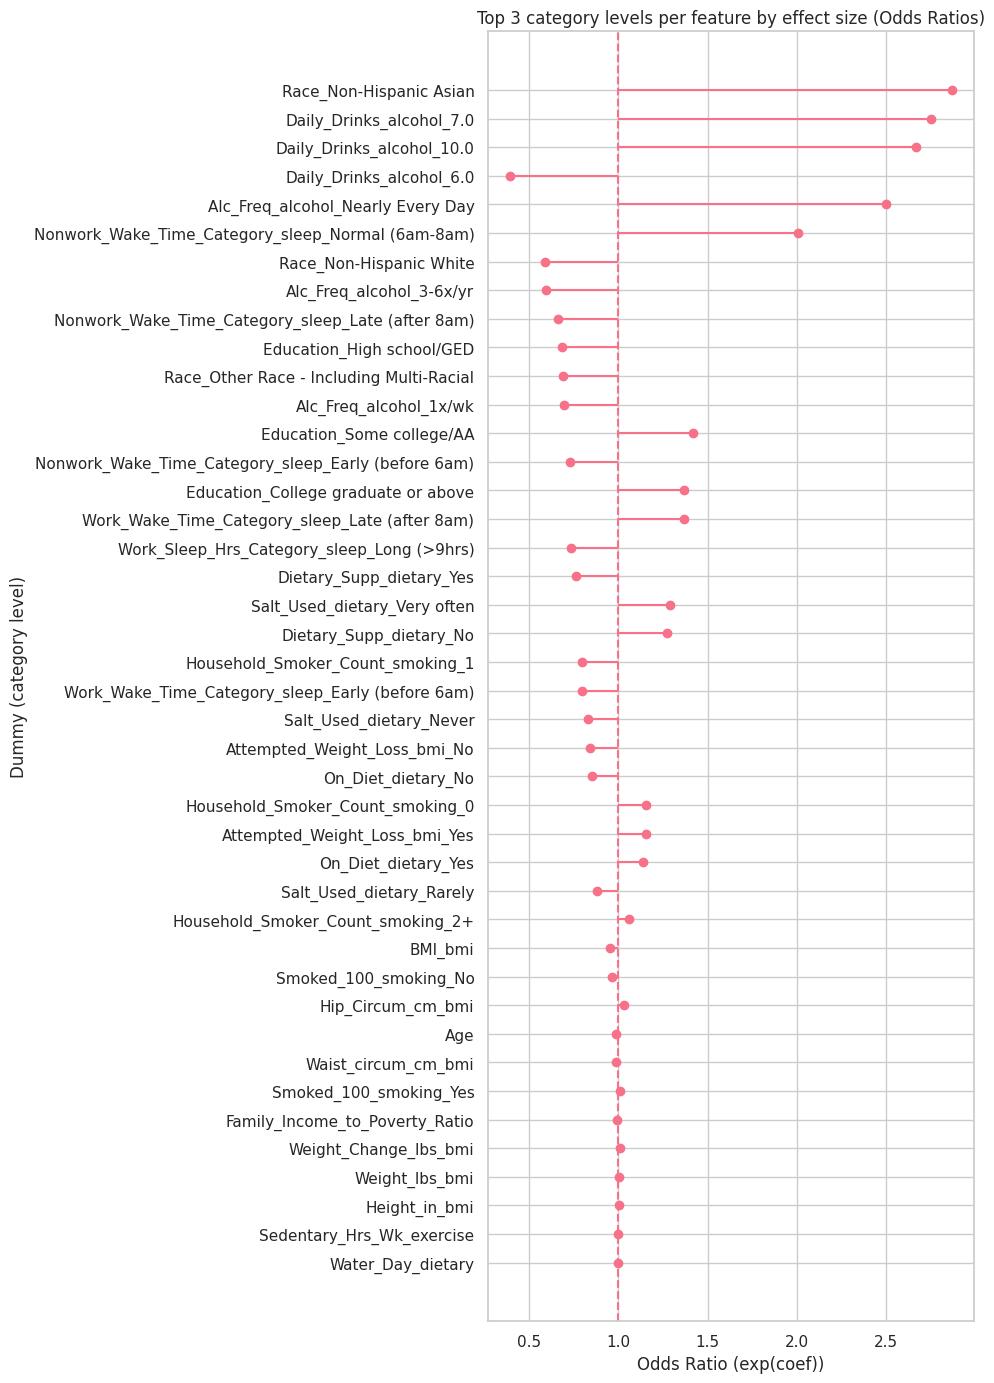

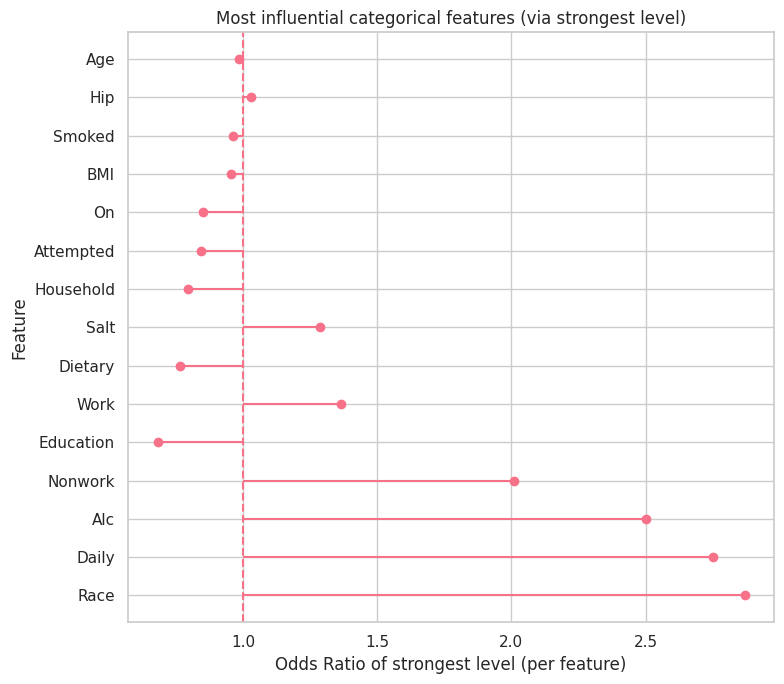

In [3041]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Build an odds-ratio table from your fitted model
def make_odds_df(logreg, X_train):
    coef = logreg.coef_[0]
    odds = np.exp(coef)
    df = pd.DataFrame({
        "feature": X_train.columns,
        "coef": coef,
        "odds_ratio": odds,
        "log_or_abs": np.abs(coef),  # |log(OR)| = effect magnitude
    })
    return df

# 2) Infer the original categorical "group" from dummy names.
#    If you used a custom prefix_sep in get_dummies, put it here.
def infer_group(col, prefer_sep="__"):
    if prefer_sep in col:
        return col.split(prefer_sep, 1)[0]
    # fallback: split on first underscore
    if "_" in col:
        return col.split("_", 1)[0]
    return col

def add_groups(odds_df, prefer_sep="__"):
    odds_df = odds_df.copy()
    odds_df["group"] = odds_df["feature"].apply(lambda c: infer_group(c, prefer_sep))
    return odds_df

# 3) Plot: per-dummy odds ratios, grouped (horizontal bars)
def plot_grouped_odds(odds_df, top_n_per_group=3):
    df = odds_df.sort_values("log_or_abs", ascending=False)
    # take top k per group to keep plot readable
    df = df.groupby("group", group_keys=False).head(top_n_per_group)

    # order bars by effect size
    df = df.sort_values("log_or_abs", ascending=True)

    plt.figure(figsize=(10, max(5, int(len(df) * 0.35))))
    plt.hlines(y=df["feature"], xmin=1, xmax=df["odds_ratio"])
    plt.plot(df["odds_ratio"], df["feature"], "o")
    plt.axvline(1.0, linestyle="--")
    plt.xlabel("Odds Ratio (exp(coef))")
    plt.ylabel("Dummy (category level)")
    plt.title(f"Top {top_n_per_group} category levels per feature by effect size (Odds Ratios)")
    plt.tight_layout()
    plt.show()

# 4) Plot: collapsed to one bar per original feature (direction of strongest level)
def plot_group_summary(odds_df, top_groups=15):
    # choose each group's strongest level by |log(OR)|, keep its sign for direction
    strongest = (
        odds_df.loc[odds_df.groupby("group")["log_or_abs"].idxmax()]
        .sort_values("log_or_abs", ascending=False)
        .head(top_groups)
    )
    plt.figure(figsize=(8, max(5, int(len(strongest)*0.5))))
    y = strongest["group"]
    x = strongest["odds_ratio"]
    plt.hlines(y=y, xmin=1, xmax=x)
    plt.plot(x, y, "o")
    plt.axvline(1.0, linestyle="--")
    plt.xlabel("Odds Ratio of strongest level (per feature)")
    plt.ylabel("Feature")
    plt.title("Most influential categorical features (via strongest level)")
    plt.tight_layout()
    plt.show()

# ===== Use it =====
# After you've fit:
# logreg.fit(X_train, y_train)

odds_df = make_odds_df(logreg, X_train)

# If you created dummies like: pd.get_dummies(..., prefix_sep="__"),
# pass prefer_sep="__" so grouping is exact.
odds_df = add_groups(odds_df, prefer_sep="__")  # change to "_" if that's what you used

# Show top category levels per feature (e.g., 2 or 3 per feature)
plot_grouped_odds(odds_df, top_n_per_group=3)

# And a concise one-bar-per-feature summary
plot_group_summary(odds_df, top_groups=15)


In [3042]:
def plot_probs_for_dummy_feature(logreg, X_train, feature_prefix):
    """
    feature_prefix: e.g. 'Exercise' if you have Exercise_Yes, Exercise_No
                    or 'Diet' if you have Diet_Poor, Diet_Medium, Diet_Good
    """

    baseline_row = X_train.median(axis=0)  # start with typical values

    # find all dummy columns for this feature
    group_cols = [c for c in X_train.columns if c.startswith(feature_prefix + "_")]
    categories, probs = [], []

    # loop through each dummy column (each category)
    for col in group_cols:
        row = baseline_row.copy()
        # set all categories in this group to 0
        for c in group_cols:
            row[c] = 0
        # turn this one on
        row[col] = 1
        p = logreg.predict_proba(pd.DataFrame([row]))[:,1][0]
        categories.append(col.split("_", 1)[1])  # take part after prefix
        probs.append(p)

    # if drop_first=True was used, add baseline category (all 0’s)
    if len(group_cols) < len(set([c.split("_",1)[0] for c in X_train.columns])):
        row = baseline_row.copy()
        for c in group_cols:
            row[c] = 0
        p = logreg.predict_proba(pd.DataFrame([row]))[:,1][0]
        categories.insert(0, "Baseline")
        probs.insert(0, p)

    # plot
    plt.figure(figsize=(6,4))
    sns.barplot(x=categories, y=probs, color="skyblue")
    plt.axhline(0.5, color="red", linestyle="--")
    plt.ylabel("Predicted probability (target=1)")
    plt.xlabel(feature_prefix)
    plt.title(f"Predicted probabilities by {feature_prefix}")
    plt.show()

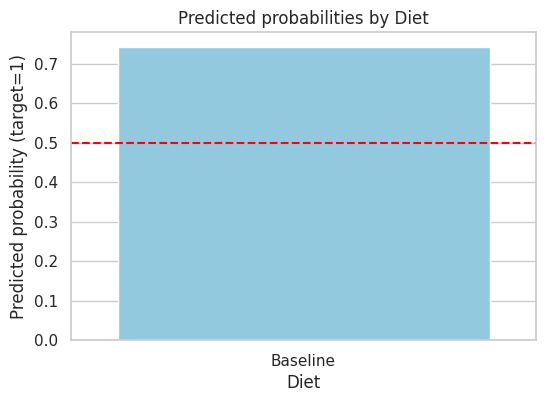

In [1588]:
plot_probs_for_dummy_feature(logreg, X_train, "Diet")